<b>Section 0</b>: Total prediction process (Visualization)

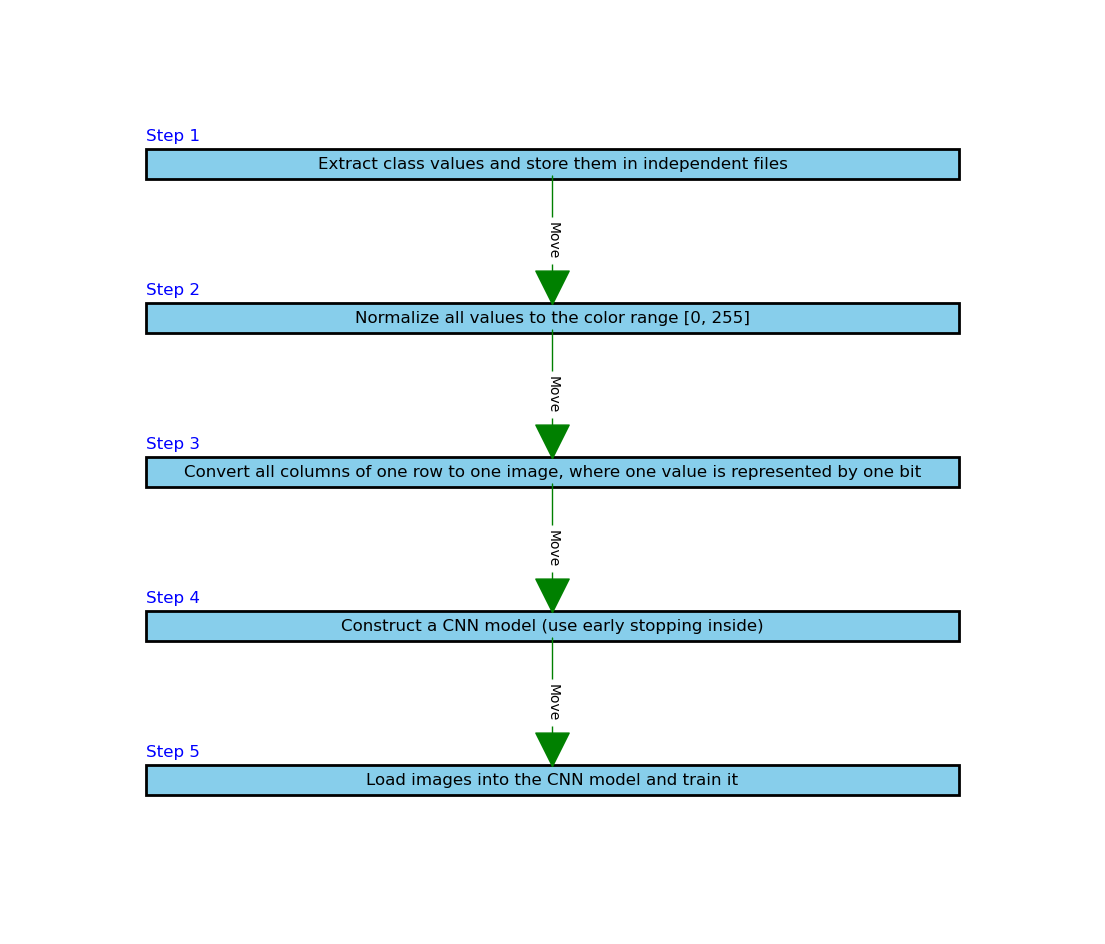

In [2]:
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib.patches as patches

G = nx.DiGraph()

nodes = [
    "Extract class values and store them in independent files",
    "Normalize all values to the color range [0, 255]",
    "Convert all columns of one row to one image, where one value is represented by one bit",
    "Construct a CNN model (use early stopping inside)",
    "Load images into the CNN model and train it"
]
G.add_nodes_from(nodes)

edges = [
    ("Extract class values and store them in independent files", 
     "Normalize all values to the color range [0, 255]", "Move"),
    ("Normalize all values to the color range [0, 255]", 
     "Convert all columns of one row to one image, where one value is represented by one bit", "Move"),
    ("Convert all columns of one row to one image, where one value is represented by one bit", 
     "Construct a CNN model (use early stopping inside)", "Move"),
    ("Construct a CNN model (use early stopping inside)", 
     "Load images into the CNN model and train it", "Move")
]

for u, v, label in edges:
    G.add_edge(u, v, label=label)

pos = {
    "Extract class values and store them in independent files": (0, 4),
    "Normalize all values to the color range [0, 255]": (0, 3),
    "Convert all columns of one row to one image, where one value is represented by one bit": (0, 2),
    "Construct a CNN model (use early stopping inside)": (0, 1),
    "Load images into the CNN model and train it": (0, 0)
}

plt.figure(figsize=(14, 12))

node_width = 15000
node_height = 2000
arrow_size = 60

ax = plt.gca()

for node, (x, y) in pos.items():
    rect = patches.Rectangle((x - node_width / 2e4, y - node_height / 2e4), 
                             node_width / 1e4, node_height / 1e4, 
                             edgecolor='black', facecolor='skyblue', linewidth=2)
    ax.add_patch(rect)
    plt.text(x, y, node, fontsize=12, ha='center', va='center', color='black')

for i, (node, (x, y)) in enumerate(pos.items(), start=1):
    plt.text(x - 0.7, y + 0.18, f"Step {i}", fontsize=12, ha='center', va='center', color='blue')

nx.draw_networkx_edges(G, pos, arrowstyle="-|>", arrowsize=arrow_size, edge_color="green")

edge_labels = nx.get_edge_attributes(G, 'label')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)

plt.xlim(-1, 1)
plt.ylim(-1, 5)
plt.axis("off")

plt.show()

<b>Section 1</b>: Preparation steps

In [1]:
import pandas as pd

file_path = 'mixalldata_clean.csv'
df = pd.read_csv(file_path, nrows=1)

print("Column names in the dataset:")
print(df.columns)

Column names in the dataset:
Index(['type', 'sendTime', 'sender', 'senderPseudo', 'messageID', 'class',
       'posx', 'posy', 'posz', 'posx_n', 'posy_n', 'posz_n', 'spdx', 'spdy',
       'spdz', 'spdx_n', 'spdy_n', 'spdz_n', 'aclx', 'acly', 'aclz', 'aclx_n',
       'acly_n', 'aclz_n', 'hedx', 'hedy', 'hedz', 'hedx_n', 'hedy_n',
       'hedz_n'],
      dtype='object')


In [3]:
import pandas as pd

# Load the dataset
file_path = 'mixalldata_clean.csv'
df = pd.read_csv(file_path)

# Specify numeric columns
numeric_columns = [
    'sendTime', 'senderPseudo', 'posx', 'posy', 'posz', 'posx_n', 'posy_n', 'posz_n',
    'spdx', 'spdy', 'spdz', 'spdx_n', 'spdy_n', 'spdz_n',
    'aclx', 'acly', 'aclz', 'aclx_n', 'acly_n', 'aclz_n',
    'hedx', 'hedy', 'hedz', 'hedx_n', 'hedy_n', 'hedz_n', 'class'
]
df[numeric_columns] = df[numeric_columns].apply(pd.to_numeric, errors='coerce')

# Sort by 'sender' and 'sendTime' for time-sequential ordering within each sender
df = df.sort_values(by=['senderPseudo', 'sendTime']).reset_index(drop=True)

# Separate filtered records into misbehavior and normal classes
misbehavior_records = df[df['class'] != 0]
normal_records = df[df['class'] == 0]

# Sample 2000 records per misbehavior class, ensuring each sender has at least 5 occurrences
misbehavior_sample = (
    misbehavior_records.groupby('class')
    .apply(lambda x: x.head(2500))
    .reset_index(drop=True)
)

# Calculate the remaining sample size needed from normal records to reach 100,000 total
normal_sample_size = 125000 - len(misbehavior_sample)

# Sample normal records while ensuring each sender occurs at least 5 times
normal_sample = (
    normal_records.groupby('sender')
    .apply(lambda x: x.head(5))  # Take at least 5 records per sender
    .reset_index(drop=True)
)

# If additional normal records are needed, sample from remaining normal records
additional_normal_records_needed = normal_sample_size - len(normal_sample)
if additional_normal_records_needed > 0:
    remaining_normal_sample = (
        normal_records[~normal_records.index.isin(normal_sample.index)]
        .sample(n=additional_normal_records_needed, random_state=42)
    )
    normal_sample = pd.concat([normal_sample, remaining_normal_sample])

# Combine misbehavior and normal samples, and sort by 'sendTime' for a sequential dataset
final_df = pd.concat([normal_sample, misbehavior_sample]).sort_values(by='sendTime').reset_index(drop=True)

# Display final class distribution to verify balance and sender occurrence condition
print("Class distribution in final dataset:")
print(final_df['class'].value_counts())

# Verify each sender appears at least 5 times in the final dataset
sender_occurrences = final_df['sender'].value_counts()
print("All senders have at least 5 occurrences:", (sender_occurrences >= 5).all())

Class distribution in final dataset:
0     85989
18     2500
1      2500
2      2500
3      2500
4      2500
5      2500
6      2500
7      2500
8      2500
19     2500
10     2500
11     2500
12     2500
13     2500
14     2500
15     2500
16     2500
17     2500
9      2500
Name: class, dtype: int64
All senders have at least 5 occurrences: False


In [5]:
# Find all distinct (unique) values in the 'OBU_device_ID' column
distinct_senders = final_df['sender'].unique()

print("Distinct senders:")
print(distinct_senders)
print("Total senders: " + str(len(distinct_senders)))

Distinct senders:
[    93    213    303    471    531    663    735    789    855    915
    921    975   1113   1269   1287   1293   1323   1491   1521   1557
   1671   1731   1815   1851   1869   1875   2049   2055   2115   2139
   2235   2265   2325   2373   2493   2571   2751   2871   3069   3081
   3135   3333   3423   3549   3753   3891   4131   4815   4851   4893
   5031   5235   5613   6243   6375   7203   7209   7323   7623   7905
   8025   8067   8703   8763   8883   9297   9489   9957   9981  10863
  11085  11121  11601  12165  12747  12885  13143  13239  13329  13629
  13947  14439  14445  14451  14559  14577  14763  14895  14961  15003
  15117  15147  15807  15819  15825  16305  16605  16995  17247  17883
  17997  18279  18339  18387  18873  19059  19125  19275  19809  19935
  20175  20253  20337  20589  20625  20655  20703  20925  21501  21921
  21981  22095  22377  22521  22557  23385  24009  24129  24159  24243
  24267  24441  24699  25197  25209  25641  25707  25779  2

In [6]:
# Display the first 10 records with sender and sendTime
pd.set_option('display.float_format', '{:.0f}'.format)
print(df[['sender', 'sendTime']].head(10))

   sender  sendTime
0       9       241
1       9       242
2       9       243
3       9       244
4       9       245
5       9       246
6       9       247
7       9       248
8       9       249
9       9       250


<b>Section 2</b>: Execution

In [4]:
import numpy as np
import pandas as pd
from PIL import Image
import os

final_numeric_columns = [
    'sendTime', 'senderPseudo', 'posx', 'posy', 'posx_n', 'posy_n',
    'spdx_n', 'spdy_n', 'aclx_n', 'acly_n', 'hedx_n', 'hedy_n'
]

min_max_values = {
    col: (final_df[col].min(), final_df[col].max()) for col in final_numeric_columns if col != 'class'
}

FAC_IMAGE_WIDTH = 5
FAC_IMAGE_HEIGHT = 5
FAC_NUM_CHANNELS = 12
FAC_SPECIAL_VALUE = 255

def normalize_and_scale(value, min_value, max_value):
    if pd.isna(value) or not np.isfinite(value):
        return FAC_SPECIAL_VALUE
    if max_value == min_value:
        return 0 if value == min_value else FAC_SPECIAL_VALUE
    scaled_value = 255 * (value - min_value) / (max_value - min_value)
    return int(np.clip(scaled_value, 0, 255))

def records_to_image_v4(group, misbehavior_index=None):
    image_data = np.zeros((FAC_IMAGE_HEIGHT, FAC_IMAGE_WIDTH, FAC_NUM_CHANNELS), dtype=np.uint8)
    obu_ids = np.empty((FAC_IMAGE_HEIGHT, FAC_IMAGE_WIDTH), dtype=object)
    timestamps = np.empty((FAC_IMAGE_HEIGHT, FAC_IMAGE_WIDTH), dtype=object)

    if len(group) < FAC_IMAGE_WIDTH * FAC_IMAGE_HEIGHT:
        print(f"Not enough rows in the group (needed {FAC_IMAGE_WIDTH * FAC_IMAGE_HEIGHT}, got {len(group)}). Returning an empty image.")
        return np.full((FAC_IMAGE_HEIGHT, FAC_IMAGE_WIDTH, FAC_NUM_CHANNELS), FAC_SPECIAL_VALUE, dtype=np.uint8), obu_ids, timestamps

    unique_senders = group['senderPseudo'].unique()

    for row_index in range(FAC_IMAGE_HEIGHT):
        is_misbehavior_row = misbehavior_index is not None and (row_index * FAC_IMAGE_WIDTH <= misbehavior_index - 1 < (row_index + 1) * FAC_IMAGE_WIDTH)

        if is_misbehavior_row:
            misbehavior_row = group.sample(n=1).iloc[0]
            selected_sender = misbehavior_row['senderPseudo']

            sender_records = group[group['senderPseudo'] == selected_sender]
            if len(sender_records) < 5:
                sender_records = sender_records.sample(n=5, replace=True, random_state=row_index)

            sender_records = sender_records.reset_index(drop=True)

            for col_index in range(FAC_IMAGE_WIDTH):
                for channel_index, col in enumerate(final_numeric_columns):
                    min_value, max_value = min_max_values[col]
                    value = normalize_and_scale(sender_records.iloc[col_index][col], min_value, max_value)
                    image_data[row_index, col_index, channel_index] = value

                obu_ids[row_index, col_index] = selected_sender
                timestamps[row_index, col_index] = misbehavior_row['sendTime'] + col_index

            misbehavior_col = (misbehavior_index - 1) % FAC_IMAGE_WIDTH
            image_data[row_index, misbehavior_col, 0] = 255
            image_data[row_index, misbehavior_col, 1] = 0

        else:
            selected_sender = np.random.choice(unique_senders)
            sender_records = group[group['senderPseudo'] == selected_sender]
            if len(sender_records) < 5:
                sender_records = sender_records.sample(n=5, replace=True, random_state=row_index)

            sender_records = sender_records.sort_values('sendTime').reset_index(drop=True)

            base_time = sender_records.iloc[0]['sendTime']
            for col_index in range(FAC_IMAGE_WIDTH):
                for channel_index, col in enumerate(final_numeric_columns):
                    min_value, max_value = min_max_values[col]
                    value = normalize_and_scale(sender_records.iloc[col_index][col], min_value, max_value)
                    image_data[row_index, col_index, channel_index] = value
                    
                obu_ids[row_index, col_index] = selected_sender
                timestamps[row_index, col_index] = base_time + col_index

    return image_data, obu_ids, timestamps

normal_messages = final_df[final_df['class'] == 0]
attack_messages = final_df[final_df['class'] != 0]

output_dir = 'veremi_images_5x5_e'
os.makedirs(output_dir, exist_ok=True)

# Step 1: Create 1120 normal images, sorting by timestamp and keeping rows from the same sender
image_counter = 1
classification_results = []

normal_samples = normal_messages.groupby('sender').apply(lambda x: x.sample(n=25, replace=True)).reset_index(drop=True)

while len(classification_results) < 2000:
    rows_group = normal_samples.sort_values('sendTime')

    if len(rows_group) < 25:
        continue

    image_data, obu_ids, timestamps = records_to_image_v4(rows_group)
    
    image_name = f'{output_dir}/image_{image_counter}.png'
    Image.fromarray(image_data[:, :, :3], mode='RGB').save(image_name)

    classification_results.append({'image_name': image_name, 'classification': 0, 'misbehavior_index': 0})
    image_counter += 1

# Step 2: Create 480 images with mixed normal and attack rows
for i in range(800):
    normal_sampled_senders = normal_samples.sample(n=25, random_state=i)
    attack_messages_sample = attack_messages.sample(n=25, random_state=i)
    
    rows_group = pd.concat([normal_sampled_senders, attack_messages_sample]).sort_values('sendTime')

    misbehavior_index = np.random.randint(1, 26)

    image_data, obu_ids, timestamps = records_to_image_v4(rows_group, misbehavior_index)

    image_name = f'{output_dir}/image_{image_counter}.png'
    Image.fromarray(image_data[:, :, :3], mode='RGB').save(image_name)
    
    classification_results.append({'image_name': image_name, 'classification': 1, 'misbehavior_index': misbehavior_index})  # Misbehavior images have indices 1-25
    image_counter += 1

classification_df = pd.DataFrame(classification_results)
classification_df.to_csv('class_5x5_e.csv', index=False)

print("New classification results saved to 'class_5x5_e.csv'.") 

New classification results saved to 'class_5x5_e.csv'.


In [5]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, BatchNormalization, Flatten, Dense, Input
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import os
import time

FAC_IMAGE_SIZE = (5, 5, 12)
FAC_IMAGE_DIR = 'veremi_images_5x5_e'
FAC_BATCH_SIZE = 32
FAC_EPOCHS = 10

fac_labels_df = pd.read_csv('class_5x5_e.csv')

fac_labels_df['classification'].fillna(-1, inplace=True)
fac_labels_df['misbehavior_index'].fillna(-1, inplace=True)

fac_labels = fac_labels_df[['classification', 'misbehavior_index']].values

valid_indices = (fac_labels[:, 0] != -1) & (fac_labels[:, 1] != -1)
fac_labels = fac_labels[valid_indices]
fac_num_images = len(fac_labels)

def load_images(fac_image_dir, fac_num_images):
    X = []
    Y_classification = []
    Y_index = []
    
    for idx in range(fac_num_images):
        image_path = os.path.join(fac_image_dir, f'image_{idx + 1}.png')
        if os.path.exists(image_path):
            image = load_img(image_path, color_mode='grayscale', target_size=(FAC_IMAGE_SIZE[0], FAC_IMAGE_SIZE[1]))
            image_array = img_to_array(image) / 255.0

            if image_array.shape[-1] == 1:
                image_array = np.concatenate([image_array] * 12, axis=-1)
                X.append(image_array)
                Y_classification.append(int(fac_labels[idx][0]))
                Y_index.append(int(fac_labels[idx][1]))
            else:
                print(f"Warning: Unexpected channel size {image_array.shape[-1]} for {image_path}.")
                continue
        else:
            print(f"Warning: {image_path} not found.")
    
    X = np.array(X, dtype=np.float32)
    Y_classification = np.array(Y_classification, dtype=int)
    Y_index = np.array(Y_index, dtype=int)

    return X, Y_classification, Y_index

X, Y_classification, Y_index = load_images(FAC_IMAGE_DIR, fac_num_images)

X_train, X_test, Y_train_classification, Y_test_classification, Y_train_index, Y_test_index = train_test_split(
    X, Y_classification, Y_index, test_size=0.2, random_state=42)

input_layer = Input(shape=(FAC_IMAGE_SIZE[0], FAC_IMAGE_SIZE[1], 12))

x = Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(input_layer)
x = BatchNormalization()(x)
x = Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Flatten()(x)
x = Dense(192, activation='relu')(x)
x = BatchNormalization()(x)

classification_output = Dense(2, activation='softmax', name='classification_output')(x)

index_output = Dense(26, activation='softmax', name='index_output')(x)

model = Model(inputs=input_layer, outputs=[classification_output, index_output])

model.compile(optimizer='adam', 
              loss={'classification_output': 'sparse_categorical_crossentropy', 
                    'index_output': 'sparse_categorical_crossentropy'},
              metrics={'classification_output': 'accuracy', 'index_output': 'accuracy'})

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

start_time = time.time()
model.fit(X_train, 
          {'classification_output': Y_train_classification, 'index_output': Y_train_index}, 
          epochs=FAC_EPOCHS, 
          batch_size=FAC_BATCH_SIZE, 
          validation_data=(X_test, {'classification_output': Y_test_classification, 'index_output': Y_test_index}),
          callbacks=[early_stopping])

predictions = model.predict(X_test)
Y_pred_classification = np.argmax(predictions[0], axis=1)
Y_pred_index = np.argmax(predictions[1], axis=1)

accuracy_classification = accuracy_score(Y_test_classification, Y_pred_classification)
precision_classification = precision_score(Y_test_classification, Y_pred_classification, average='macro')
recall_classification = recall_score(Y_test_classification, Y_pred_classification, average='macro')
f1_classification = f1_score(Y_test_classification, Y_pred_classification, average='macro')

accuracy_index = accuracy_score(Y_test_index, Y_pred_index)

f1_classification_manual = 2 * (precision_classification * recall_classification) / (precision_classification + recall_classification)

print("Classification Accuracy:", accuracy_classification)
print("Classification Precision:", precision_classification)
print("Classification Recall:", recall_classification)
print("Classification F1-score (sklearn):", f1_classification)
print("Classification F1-score (manual calculation):", f1_classification_manual)

print("Misbehavior Index Accuracy:", accuracy_index)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"\nTraining time: {elapsed_time:.6f} seconds")

Epoch 1/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - classification_output_accuracy: 0.7148 - classification_output_loss: 0.7225 - index_output_accuracy: 0.4225 - index_output_loss: 2.8218 - loss: 3.5443 - val_classification_output_accuracy: 0.7214 - val_classification_output_loss: 0.6143 - val_index_output_accuracy: 0.7214 - val_index_output_loss: 1.8412 - val_loss: 2.4505
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - classification_output_accuracy: 0.8376 - classification_output_loss: 0.3967 - index_output_accuracy: 0.6957 - index_output_loss: 1.4926 - loss: 1.8893 - val_classification_output_accuracy: 0.7250 - val_classification_output_loss: 0.6058 - val_index_output_accuracy: 0.7214 - val_index_output_loss: 1.5655 - val_loss: 2.1683
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - classification_output_accuracy: 0.8567 - classification_output_loss: 0.3525 - index_output_accuracy: 0.7354 - index_output_loss: 1.2387 - loss: 1.5912 - val_classification_output_accuracy: 0.81

In [21]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Conv2D, BatchNormalization, Dense, Input, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import os
import time

FAC_IMAGE_SIZE = (5, 5, 12)
FAC_IMAGE_DIR = 'veremi_images_5x5_e'
FAC_BATCH_SIZE = 64
FAC_EPOCHS = 20
L2 = 1e-4

fac_labels_df = pd.read_csv('class_5x5_e.csv')
fac_labels_df['classification'].fillna(-1, inplace=True)
fac_labels_df['misbehavior_index'].fillna(-1, inplace=True)
fac_labels = fac_labels_df[['classification', 'misbehavior_index']].values
valid_indices = (fac_labels[:, 0] != -1) & (fac_labels[:, 1] != -1)
fac_labels = fac_labels[valid_indices]
fac_num_images = len(fac_labels)

def load_images(fac_image_dir, fac_num_images):
    X, Y_classification, Y_index = [], [], []
    for idx in range(fac_num_images):
        image_path = os.path.join(fac_image_dir, f'image_{idx + 1}.png')
        if os.path.exists(image_path):
            image = load_img(image_path, color_mode='grayscale', target_size=(FAC_IMAGE_SIZE[0], FAC_IMAGE_SIZE[1]))
            image_array = img_to_array(image) / 255.0
            if image_array.shape[-1] == 1:
                image_array = np.concatenate([image_array] * 12, axis=-1)
                X.append(image_array)
                Y_classification.append(int(fac_labels[idx][0]))
                Y_index.append(int(fac_labels[idx][1]))
    X = np.array(X, dtype=np.float32)
    Y_classification = np.array(Y_classification, dtype=int)
    Y_index = np.array(Y_index, dtype=int)
    return X, Y_classification, Y_index

X, Y_classification, Y_index = load_images(FAC_IMAGE_DIR, fac_num_images)

X_train, X_test, Y_train_classification, Y_test_classification, Y_train_index, Y_test_index = train_test_split(
    X, Y_classification, Y_index, test_size=0.2, random_state=42, stratify=Y_classification
)

augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.1)
])

input_layer = Input(shape=(FAC_IMAGE_SIZE[0], FAC_IMAGE_SIZE[1], 12))
x = augmentation(input_layer)
x = Conv2D(96, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(L2))(x)
x = BatchNormalization()(x)
x = Dropout(0.25)(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(L2))(x)
x = BatchNormalization()(x)
x = Dropout(0.25)(x)
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(L2))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

classification_output = Dense(2, activation='softmax', name='classification_output')(x)
index_output = Dense(26, activation='softmax', name='index_output')(x)

model = Model(inputs=input_layer, outputs=[classification_output, index_output])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss={'classification_output': 'sparse_categorical_crossentropy', 'index_output': 'sparse_categorical_crossentropy'},
    metrics={'classification_output': 'accuracy', 'index_output': 'accuracy'}
)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, min_delta=1e-4)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-5)

start_time = time.time()
model.fit(
    X_train,
    {'classification_output': Y_train_classification, 'index_output': Y_train_index},
    epochs=FAC_EPOCHS,
    batch_size=FAC_BATCH_SIZE,
    validation_data=(X_test, {'classification_output': Y_test_classification, 'index_output': Y_test_index}),
    callbacks=[early_stopping, reduce_lr],
    shuffle=True
)

predictions = model.predict(X_test, batch_size=FAC_BATCH_SIZE)
Y_pred_classification = np.argmax(predictions[0], axis=1)
Y_pred_index = np.argmax(predictions[1], axis=1)

accuracy_classification = accuracy_score(Y_test_classification, Y_pred_classification)
precision_classification = precision_score(Y_test_classification, Y_pred_classification, average='macro', zero_division=0)
recall_classification = recall_score(Y_test_classification, Y_pred_classification, average='macro', zero_division=0)
f1_classification = f1_score(Y_test_classification, Y_pred_classification, average='macro', zero_division=0)

accuracy_index = accuracy_score(Y_test_index, Y_pred_index)

f1_classification_manual = 2 * (precision_classification * recall_classification) / (precision_classification + recall_classification + 1e-12)

print("Classification Accuracy:", accuracy_classification)
print("Classification Precision:", precision_classification)
print("Classification Recall:", recall_classification)
print("Classification F1-score (sklearn):", f1_classification)
print("Classification F1-score (manual calculation):", f1_classification_manual)
print("Misbehavior Index Accuracy:", accuracy_index)

end_time = time.time()
print(f"\nTraining time: {end_time - start_time:.6f} seconds")

Epoch 1/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - classification_output_accuracy: 0.6533 - classification_output_loss: 0.8806 - index_output_accuracy: 0.2173 - index_output_loss: 3.7616 - loss: 4.6605 - val_classification_output_accuracy: 0.7143 - val_classification_output_loss: 0.6007 - val_index_output_accuracy: 0.7143 - val_index_output_loss: 2.5859 - val_loss: 3.2036 - learning_rate: 0.0010
Epoch 2/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - classification_output_accuracy: 0.7684 - classification_output_loss: 0.5991 - index_output_accuracy: 0.4952 - index_output_loss: 2.6055 - loss: 3.2231 - val_classification_output_accuracy: 0.7143 - val_classification_output_loss: 0.6007 - val_index_output_accuracy: 0.7143 - val_index_output_loss: 1.9987 - val_loss: 2.6155 - learning_rate: 0.0010
Epoch 3/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - classification_output_accuracy: 0.8059 - classification_output_loss: 0.5043 - index_output_accuracy: 0.6123 - index_output_loss: 2.0958 - loss: 2

Epoch 20/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - classification_output_accuracy: 0.8549 - classification_output_loss: 0.3552 - index_output_accuracy: 0.7024 - index_output_loss: 1.4119 - loss: 1.7870 - val_classification_output_accuracy: 0.8732 - val_classification_output_loss: 0.3143 - val_index_output_accuracy: 0.7179 - val_index_output_loss: 1.2352 - val_loss: 1.5732 - learning_rate: 5.0000e-04
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Classification Accuracy: 0.8732142857142857
Classification Precision: 0.8734827264239029
Classification Recall: 0.80625
Classification F1-score (sklearn): 0.8305482038365319
Classification F1-score (manual calculation): 0.8385208397745139
Misbehavior Index Accuracy: 0.7178571428571429

Training time: 13.686107 seconds


In [6]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, BatchNormalization, Flatten, Dense, Input
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import os
import time

FAC_IMAGE_SIZE = (5, 5, 12)
FAC_IMAGE_DIR = 'veremi_images_5x5_e'
FAC_BATCH_SIZE = 32
FAC_EPOCHS = 10

fac_labels_df = pd.read_csv('class_5x5_e.csv')
fac_labels_df['classification'].fillna(-1, inplace=True)
fac_labels_df['misbehavior_index'].fillna(-1, inplace=True)
fac_labels = fac_labels_df[['classification', 'misbehavior_index']].values

valid_indices = (fac_labels[:, 0] != -1) & (fac_labels[:, 1] != -1)
fac_labels = fac_labels[valid_indices]
fac_num_images = len(fac_labels)

def load_images(fac_image_dir, fac_num_images):
    X, Y_classification, Y_index = [], [], []
    for idx in range(fac_num_images):
        image_path = os.path.join(fac_image_dir, f'image_{idx + 1}.png')
        if os.path.exists(image_path):
            image = load_img(image_path, color_mode='grayscale', target_size=(FAC_IMAGE_SIZE[0], FAC_IMAGE_SIZE[1]))
            image_array = img_to_array(image) / 255.0
            if image_array.shape[-1] == 1:
                image_array = np.concatenate([image_array] * 12, axis=-1)
                X.append(image_array)
                Y_classification.append(int(fac_labels[idx][0]))
                Y_index.append(int(fac_labels[idx][1]))
        else:
            print(f"Warning: {image_path} not found.")
    X = np.array(X, dtype=np.float32)
    Y_classification = np.array(Y_classification, dtype=int)
    Y_index = np.array(Y_index, dtype=int)
    return X, Y_classification, Y_index

X, Y_classification, Y_index = load_images(FAC_IMAGE_DIR, fac_num_images)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
accs, precs, recs, f1s, idx_accs = [], [], [], [], []
start_time = time.time()
fold = 1

for train_index, test_index in skf.split(X, Y_classification):
    X_train, X_test = X[train_index], X[test_index]
    Y_train_classification, Y_test_classification = Y_classification[train_index], Y_classification[test_index]
    Y_train_index, Y_test_index = Y_index[train_index], Y_index[test_index]

    input_layer = Input(shape=(FAC_IMAGE_SIZE[0], FAC_IMAGE_SIZE[1], 12))
    x = Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(input_layer)
    x = BatchNormalization()(x)
    x = Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Flatten()(x)
    x = Dense(192, activation='relu')(x)
    x = BatchNormalization()(x)

    classification_output = Dense(2, activation='softmax', name='classification_output')(x)
    index_output = Dense(26, activation='softmax', name='index_output')(x)

    model = Model(inputs=input_layer, outputs=[classification_output, index_output])
    model.compile(optimizer='adam',
                  loss={'classification_output': 'sparse_categorical_crossentropy',
                        'index_output': 'sparse_categorical_crossentropy'},
                  metrics={'classification_output': 'accuracy', 'index_output': 'accuracy'})
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    model.fit(X_train,
              {'classification_output': Y_train_classification, 'index_output': Y_train_index},
              epochs=FAC_EPOCHS,
              batch_size=FAC_BATCH_SIZE,
              validation_data=(X_test, {'classification_output': Y_test_classification, 'index_output': Y_test_index}),
              callbacks=[early_stopping],
              verbose=0)

    predictions = model.predict(X_test, verbose=0)
    Y_pred_classification = np.argmax(predictions[0], axis=1)
    Y_pred_index = np.argmax(predictions[1], axis=1)

    accuracy_classification = accuracy_score(Y_test_classification, Y_pred_classification)
    precision_classification = precision_score(Y_test_classification, Y_pred_classification, average='macro', zero_division=0)
    recall_classification = recall_score(Y_test_classification, Y_pred_classification, average='macro', zero_division=0)
    f1_classification = f1_score(Y_test_classification, Y_pred_classification, average='macro', zero_division=0)
    accuracy_index = accuracy_score(Y_test_index, Y_pred_index)

    print(f"Fold {fold} - Acc: {accuracy_classification:.4f}, Prec: {precision_classification:.4f}, Rec: {recall_classification:.4f}, F1: {f1_classification:.4f}, Index Acc: {accuracy_index:.4f}")

    accs.append(accuracy_classification)
    precs.append(precision_classification)
    recs.append(recall_classification)
    f1s.append(f1_classification)
    idx_accs.append(accuracy_index)
    fold += 1

print("\nCross Validation Results:")
print(f"Classification Accuracy: Mean={np.mean(accs):.4f}, Std={np.std(accs):.4f}")
print(f"Precision: Mean={np.mean(precs):.4f}, Std={np.std(precs):.4f}")
print(f"Recall: Mean={np.mean(recs):.4f}, Std={np.std(recs):.4f}")
print(f"F1-score: Mean={np.mean(f1s):.4f}, Std={np.std(f1s):.4f}")
print(f"Misbehavior Index Accuracy: Mean={np.mean(idx_accs):.4f}, Std={np.std(idx_accs):.4f}")

end_time = time.time()
elapsed_time = end_time - start_time
print(f"\nTraining time: {elapsed_time:.6f} seconds")

Fold 1 - Acc: 0.9589, Prec: 0.9728, Rec: 0.9281, F1: 0.9473, Index Acc: 0.9679
Fold 2 - Acc: 0.9857, Prec: 0.9902, Rec: 0.9750, F1: 0.9822, Index Acc: 0.9714
Fold 3 - Acc: 0.9679, Prec: 0.9785, Rec: 0.9437, F1: 0.9592, Index Acc: 0.9643
Fold 4 - Acc: 0.9571, Prec: 0.9717, Rec: 0.9250, F1: 0.9449, Index Acc: 0.9589
Fold 5 - Acc: 0.7464, Prec: 0.8690, Rec: 0.5563, F1: 0.5258, Index Acc: 0.7143

Cross Validation Results:
Classification Accuracy: Mean=0.9232, Std=0.0890
Precision: Mean=0.9564, Std=0.0442
Recall: Mean=0.8656, Std=0.1557
F1-score: Mean=0.8719, Std=0.1736
Misbehavior Index Accuracy: Mean=0.9154, Std=0.1006

Training time: 45.015742 seconds


In [26]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import os
import random
from tensorflow.keras.models import load_model
import time

start_time = time.time()

FAC_IMAGE_DIR = 'veremi_images_5x5_e'
FAC_LABELS_CSV = 'class_5x5_e.csv'

fac_labels_df = pd.read_csv(FAC_LABELS_CSV)

fac_labels_df['classification'].fillna(-1, inplace=True)
fac_labels_df['misbehavior_index'].fillna(-1, inplace=True)

valid_indices = (fac_labels_df['classification'] != -1) & (fac_labels_df['misbehavior_index'] != -1)
valid_labels = fac_labels_df[valid_indices]

random_index = random.choice(valid_labels.index)
selected_label = valid_labels.loc[random_index]
selected_image_path = os.path.join(FAC_IMAGE_DIR, f'image_{random_index + 1}.png')

image = load_img(selected_image_path, color_mode='grayscale', target_size=(FAC_IMAGE_SIZE[0], FAC_IMAGE_SIZE[1]))
image_array = img_to_array(image) / 255.0

image_array = np.concatenate([image_array] * 12, axis=-1)
image_array = np.expand_dims(image_array, axis=0)

predictions = model.predict(image_array)
predicted_classification = np.argmax(predictions[0], axis=1)[0]
predicted_index = np.argmax(predictions[1], axis=1)[0]

print(f"Selected Image Path: {selected_image_path}")
print(f"True Classification: {selected_label['classification']}, True Misbehavior Index: {selected_label['misbehavior_index']}")
print(f"Predicted Classification: {predicted_classification}, Predicted Misbehavior Index: {predicted_index}")

end_time = time.time()
elapsed_time = end_time - start_time
print(f"\nElapsed time: {elapsed_time:.6f} seconds")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Selected Image Path: veremi_images_5x5_e\image_2199.png
True Classification: 1, True Misbehavior Index: 7
Predicted Classification: 1, Predicted Misbehavior Index: 0

Elapsed time: 0.074318 seconds


In [27]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix
import os
import random
import time

FAC_IMAGE_SIZE = (5, 5, 12)
FAC_IMAGE_DIR = 'veremi_images_5x5_e'
FAC_LABELS_CSV = 'class_5x5_e.csv'
NUM_SAMPLES = 500
TIME_THRESHOLD = 0.1

fac_labels_df = pd.read_csv(FAC_LABELS_CSV)
fac_labels_df['classification'].fillna(-1, inplace=True)
fac_labels_df['misbehavior_index'].fillna(-1, inplace=True)

valid_indices = (fac_labels_df['classification'] != -1) & (fac_labels_df['misbehavior_index'] != -1)
valid_labels = fac_labels_df[valid_indices]

total_classification_correct = 0
total_index_correct = 0
total_prediction_time = 0.0
predictions_above_threshold = 0
total_samples_processed = 0

true_classifications = []
predicted_classifications = []
true_indices = []
predicted_indices = []

for _ in range(NUM_SAMPLES):
    random_index = random.choice(valid_labels.index)
    selected_label = valid_labels.loc[random_index]
    selected_image_path = os.path.join(FAC_IMAGE_DIR, f'image_{random_index + 1}.png')

    if not os.path.exists(selected_image_path):
        continue

    image = load_img(selected_image_path, color_mode='grayscale', target_size=(FAC_IMAGE_SIZE[0], FAC_IMAGE_SIZE[1]))
    image_array = img_to_array(image) / 255.0
    image_array = np.concatenate([image_array] * 12, axis=-1)
    image_array = np.expand_dims(image_array, axis=0)

    start_time = time.time()
    predictions = model.predict(image_array)
    end_time = time.time()

    prediction_time = end_time - start_time
    total_prediction_time += prediction_time
    if prediction_time >= TIME_THRESHOLD:
        predictions_above_threshold += 1

    predicted_classification = np.argmax(predictions[0], axis=1)[0]
    predicted_index = np.argmax(predictions[1], axis=1)[0]

    true_classifications.append(int(selected_label['classification']))
    predicted_classifications.append(predicted_classification)
    true_indices.append(int(selected_label['misbehavior_index']))
    predicted_indices.append(predicted_index)

    if predicted_classification == int(selected_label['classification']):
        total_classification_correct += 1
    if predicted_index == int(selected_label['misbehavior_index']):
        total_index_correct += 1

    total_samples_processed += 1

classification_cm = confusion_matrix(true_classifications, predicted_classifications)
index_cm = confusion_matrix(true_indices, predicted_indices)

def calculate_metrics(cm):
    tp = np.diag(cm)
    fp = np.sum(cm, axis=0) - tp
    fn = np.sum(cm, axis=1) - tp
    total = np.sum(cm)

    precision = np.nan_to_num(tp / (tp + fp))
    recall = np.nan_to_num(tp / (tp + fn))
    f1 = np.nan_to_num(2 * (precision * recall) / (precision + recall))

    accuracy = np.sum(tp) / total if total > 0 else 0.0

    return accuracy, precision, recall, f1

classification_accuracy, classification_precision, classification_recall, classification_f1 = calculate_metrics(classification_cm)
index_accuracy, index_precision, index_recall, index_f1 = calculate_metrics(index_cm)

print("\nClassification Metrics:")
print(f"Accuracy: {classification_accuracy:.2f}")
#print(f"Precision (per class): {classification_precision}")
#print(f"Recall (per class): {classification_recall}")
#print(f"F1-Score (per class): {classification_f1}")
print(f"Average Precision: {np.mean(classification_precision):.2f}")
print(f"Average Recall: {np.mean(classification_recall):.2f}")
print(f"Average F1-Score: {np.mean(classification_f1):.2f}")

print("\nIndex Prediction Metrics:")
print(f"Accuracy: {index_accuracy:.2f}")
#print(f"Precision (per class): {index_precision}")
#print(f"Recall (per class): {index_recall}")
#print(f"F1-Score (per class): {index_f1}")
print(f"Average Precision: {np.mean(index_precision):.2f}")
print(f"Average Recall: {np.mean(index_recall):.2f}")
print(f"Average F1-Score: {np.mean(index_f1):.2f}")

print(f"\nAverage Prediction Time: {total_prediction_time / total_samples_processed:.6f} seconds")
print(f"Predictions with time >= {TIME_THRESHOLD}s: {predictions_above_threshold} out of {total_samples_processed}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━

C:\Users\david\AppData\Local\Temp\ipykernel_5420\635254154.py:80: RuntimeWarning: invalid value encountered in divide
  precision = np.nan_to_num(tp / (tp + fp))
C:\Users\david\AppData\Local\Temp\ipykernel_5420\635254154.py:82: RuntimeWarning: invalid value encountered in divide
  f1 = np.nan_to_num(2 * (precision * recall) / (precision + recall))


In [12]:
import numpy as np
import pandas as pd
import os

FAC_IMAGE_WIDTH = 5
FAC_IMAGE_HEIGHT = 5
FAC_NUM_CHANNELS = 12
FAC_SPECIAL_VALUE = 255

def normalize_and_scale(values, min_values, max_values):
    scaled = 255 * (values - min_values) / (max_values - min_values)
    scaled[np.isnan(values) | ~np.isfinite(values)] = FAC_SPECIAL_VALUE
    scaled[values == max_values] = 0
    return np.clip(scaled, 0, 255).astype(np.uint8)

def generate_image(group, misbehavior_index=None):
    min_values = np.array([group[col].min() for col in final_numeric_columns])
    max_values = np.array([group[col].max() for col in final_numeric_columns])

    data = group[final_numeric_columns].to_numpy()
    normalized_data = normalize_and_scale(data, min_values, max_values)

    reshaped_data = normalized_data.reshape(FAC_IMAGE_HEIGHT, FAC_IMAGE_WIDTH, FAC_NUM_CHANNELS)

    if misbehavior_index:
        row = (misbehavior_index - 1) // FAC_IMAGE_WIDTH
        col = (misbehavior_index - 1) % FAC_IMAGE_WIDTH
        reshaped_data[row, col, :2] = [255, 0]
        
    return reshaped_data

final_numeric_columns = [
    'sendTime', 'sender', 'posx', 'posy', 'posx_n', 'posy_n',
    'spdx_n', 'spdy_n', 'aclx_n', 'acly_n', 'hedx_n', 'hedy_n'
]

output_dir = 'veremi_images_5x5_ea'
os.makedirs(output_dir, exist_ok=True)

normal_messages = final_df[final_df['class'] == 0]
attack_messages = final_df[final_df['class'] == 1]

classification_results = []
image_counter = 1

for _ in range(1120):
    sampled_group = normal_messages.sample(n=FAC_IMAGE_WIDTH * FAC_IMAGE_HEIGHT, random_state=image_counter)
    image_data = generate_image(sampled_group)
    npy_name = f'{output_dir}/image_{image_counter}.npy'
    np.save(npy_name, image_data)
    classification_results.append({'file_name': npy_name, 'classification': 0, 'misbehavior_index': 0})
    image_counter += 1

for _ in range(480):
    normal_group = normal_messages.sample(n=20, random_state=image_counter)
    attack_group = attack_messages.sample(n=5, random_state=image_counter)
    combined_group = pd.concat([normal_group, attack_group])
    misbehavior_index = np.random.randint(1, FAC_IMAGE_WIDTH * FAC_IMAGE_HEIGHT + 1)
    image_data = generate_image(combined_group, misbehavior_index)
    npy_name = f'{output_dir}/image_{image_counter}.npy'
    np.save(npy_name, image_data)
    classification_results.append({'file_name': npy_name, 'classification': 1, 'misbehavior_index': misbehavior_index})
    image_counter += 1

classification_df = pd.DataFrame(classification_results)
classification_df.to_csv('class_5x5_ea.csv', index=False)

print("Images generated and saved to 'veremi_images_5x5_ea'.")

Images generated and saved to 'veremi_images_5x5_ea'.


In [28]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, BatchNormalization, Flatten, Dense, Input
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import os
import time

FAC_IMAGE_SIZE = (5, 5, 12)
FAC_IMAGE_DIR = 'veremi_images_5x5_ea'
FAC_BATCH_SIZE = 32
FAC_EPOCHS = 10

fac_labels_df = pd.read_csv('class_5x5_ea.csv')

fac_labels_df['classification'].fillna(-1, inplace=True)
fac_labels_df['misbehavior_index'].fillna(-1, inplace=True)

fac_labels = fac_labels_df[['classification', 'misbehavior_index']].values

valid_indices = (fac_labels[:, 0] != -1) & (fac_labels[:, 1] != -1)
fac_labels = fac_labels[valid_indices]
fac_num_images = len(fac_labels)

def load_images(fac_image_dir, fac_num_images):
    X = []
    Y_classification = []
    Y_index = []
    
    for idx in range(fac_num_images):
        image_path = os.path.join(fac_image_dir, f'image_{idx + 1}.npy')
        if os.path.exists(image_path):
            image_array = np.load(image_path)
            image_array = image_array / 255.0

            X.append(image_array)
            Y_classification.append(int(fac_labels[idx][0]))
            Y_index.append(int(fac_labels[idx][1]))
        else:
            print(f"Warning: {image_path} not found.")
    
    X = np.array(X, dtype=np.float32)
    Y_classification = np.array(Y_classification, dtype=int)
    Y_index = np.array(Y_index, dtype=int)

    return X, Y_classification, Y_index

X, Y_classification, Y_index = load_images(FAC_IMAGE_DIR, fac_num_images)

X_train, X_test, Y_train_classification, Y_test_classification, Y_train_index, Y_test_index = train_test_split(
    X, Y_classification, Y_index, test_size=0.2, random_state=42)
input_layer = Input(shape=(FAC_IMAGE_SIZE[0], FAC_IMAGE_SIZE[1], 12))

x = Conv2D(filters=128, kernel_size=(1, 1), activation='relu', padding='same')(input_layer)
x = BatchNormalization()(x)
x = Conv2D(filters=64, kernel_size=(1, 1), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Flatten()(x)
x = Dense(192, activation='relu')(x)
x = BatchNormalization()(x)

classification_output = Dense(2, activation='softmax', name='classification_output')(x)

index_output = Dense(26, activation='softmax', name='index_output')(x)

model = Model(inputs=input_layer, outputs=[classification_output, index_output])

model.compile(optimizer='adam', 
              loss={'classification_output': 'sparse_categorical_crossentropy', 
                    'index_output': 'sparse_categorical_crossentropy'},
              metrics={'classification_output': 'accuracy', 'index_output': 'accuracy'})

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

start_time = time.time()
model.fit(X_train, 
          {'classification_output': Y_train_classification, 'index_output': Y_train_index}, 
          epochs=FAC_EPOCHS, 
          batch_size=FAC_BATCH_SIZE, 
          validation_data=(X_test, {'classification_output': Y_test_classification, 'index_output': Y_test_index}),
          callbacks=[early_stopping])

predictions = model.predict(X_test)
Y_pred_classification = np.argmax(predictions[0], axis=1)
Y_pred_index = np.argmax(predictions[1], axis=1)

accuracy_classification = accuracy_score(Y_test_classification, Y_pred_classification)
precision_classification = precision_score(Y_test_classification, Y_pred_classification, average='macro', zero_division=0)
recall_classification = recall_score(Y_test_classification, Y_pred_classification, average='macro', zero_division=0)
f1_classification = f1_score(Y_test_classification, Y_pred_classification, average='macro', zero_division=0)

accuracy_index = accuracy_score(Y_test_index, Y_pred_index)
f1_classification_manual = 2 * (precision_classification * recall_classification) / (precision_classification + recall_classification)

print("Classification Accuracy:", accuracy_classification)
print("Classification Precision:", precision_classification)
print("Classification Recall:", recall_classification)
print("Classification F1-score (sklearn):", f1_classification)
print("Classification F1-score (manual calculation):", f1_classification_manual)

print("Misbehavior Index Accuracy:", accuracy_index)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"\nTraining time: {elapsed_time:.6f} seconds")

Epoch 1/10
205/205 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - classification_output_accuracy: 0.9160 - classification_output_loss: 0.1820 - index_output_accuracy: 0.6352 - index_output_loss: 1.4366 - loss: 1.6186 - val_classification_output_accuracy: 0.3128 - val_classification_output_loss: 2.9648 - val_index_output_accuracy: 0.3128 - val_index_output_loss: 2.2033 - val_loss: 5.1688
Epoch 2/10
205/205 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - classification_output_accuracy: 0.9979 - classification_output_loss: 0.0098 - index_output_accuracy: 0.9999 - index_output_loss: 0.0050 - loss: 0.0148 - val_classification_output_accuracy: 0.7201 - val_classification_output_loss: 0.5001 - val_index_output_accuracy: 0.9939 - val_index_output_loss: 0.1706 - val_loss: 0.6709
Epoch 3/10
205/205 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - classification_output_accuracy: 0.9995 - classification_output_loss: 0.0035 - index_output_accuracy: 1.0000 - index_output_loss: 0.0025 - loss: 0.0061 - val_classification_output_accuracy: 1

In [29]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, BatchNormalization, Flatten, Dense, Input
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import os
import time

FAC_IMAGE_SIZE = (5, 5, 12)
FAC_IMAGE_DIR = 'veremi_images_5x5_ea'
FAC_BATCH_SIZE = 32
FAC_EPOCHS = 10

fac_labels_df = pd.read_csv('class_5x5_ea.csv')
fac_labels_df['classification'].fillna(-1, inplace=True)
fac_labels_df['misbehavior_index'].fillna(-1, inplace=True)
fac_labels = fac_labels_df[['classification', 'misbehavior_index']].values

valid_indices = (fac_labels[:, 0] != -1) & (fac_labels[:, 1] != -1)
fac_labels = fac_labels[valid_indices]
fac_num_images = len(fac_labels)

def load_images(fac_image_dir, fac_num_images):
    X, Y_classification, Y_index = [], [], []
    for idx in range(fac_num_images):
        image_path = os.path.join(fac_image_dir, f'image_{idx + 1}.npy')
        if os.path.exists(image_path):
            image_array = np.load(image_path) / 255.0
            X.append(image_array)
            Y_classification.append(int(fac_labels[idx][0]))
            Y_index.append(int(fac_labels[idx][1]))
        else:
            print(f"Warning: {image_path} not found.")
    X = np.array(X, dtype=np.float32)
    Y_classification = np.array(Y_classification, dtype=int)
    Y_index = np.array(Y_index, dtype=int)
    return X, Y_classification, Y_index

X, Y_classification, Y_index = load_images(FAC_IMAGE_DIR, fac_num_images)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
accs, precs, recs, f1s, idx_accs = [], [], [], [], []
start_time = time.time()
fold = 1

for train_index, test_index in skf.split(X, Y_classification):
    X_train, X_test = X[train_index], X[test_index]
    Y_train_classification, Y_test_classification = Y_classification[train_index], Y_classification[test_index]
    Y_train_index, Y_test_index = Y_index[train_index], Y_index[test_index]

    input_layer = Input(shape=(FAC_IMAGE_SIZE[0], FAC_IMAGE_SIZE[1], 12))
    x = Conv2D(filters=128, kernel_size=(1, 1), activation='relu', padding='same')(input_layer)
    x = BatchNormalization()(x)
    x = Conv2D(filters=64, kernel_size=(1, 1), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Flatten()(x)
    x = Dense(192, activation='relu')(x)
    x = BatchNormalization()(x)

    classification_output = Dense(2, activation='softmax', name='classification_output')(x)
    index_output = Dense(26, activation='softmax', name='index_output')(x)

    model = Model(inputs=input_layer, outputs=[classification_output, index_output])
    model.compile(optimizer='adam',
                  loss={'classification_output': 'sparse_categorical_crossentropy',
                        'index_output': 'sparse_categorical_crossentropy'},
                  metrics={'classification_output': 'accuracy', 'index_output': 'accuracy'})
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    model.fit(X_train,
              {'classification_output': Y_train_classification, 'index_output': Y_train_index},
              epochs=FAC_EPOCHS,
              batch_size=FAC_BATCH_SIZE,
              validation_data=(X_test, {'classification_output': Y_test_classification, 'index_output': Y_test_index}),
              callbacks=[early_stopping],
              verbose=0)

    predictions = model.predict(X_test, verbose=0)
    Y_pred_classification = np.argmax(predictions[0], axis=1)
    Y_pred_index = np.argmax(predictions[1], axis=1)

    accuracy_classification = accuracy_score(Y_test_classification, Y_pred_classification)
    precision_classification = precision_score(Y_test_classification, Y_pred_classification, average='macro', zero_division=0)
    recall_classification = recall_score(Y_test_classification, Y_pred_classification, average='macro', zero_division=0)
    f1_classification = f1_score(Y_test_classification, Y_pred_classification, average='macro', zero_division=0)
    accuracy_index = accuracy_score(Y_test_index, Y_pred_index)

    print(f"Fold {fold} - Acc: {accuracy_classification:.4f}, Prec: {precision_classification:.4f}, Rec: {recall_classification:.4f}, F1: {f1_classification:.4f}, Index Acc: {accuracy_index:.4f}")

    accs.append(accuracy_classification)
    precs.append(precision_classification)
    recs.append(recall_classification)
    f1s.append(f1_classification)
    idx_accs.append(accuracy_index)
    fold += 1

print("\nCross Validation Results:")
print(f"Classification Accuracy: Mean={np.mean(accs):.4f}, Std={np.std(accs):.4f}")
print(f"Precision: Mean={np.mean(precs):.4f}, Std={np.std(precs):.4f}")
print(f"Recall: Mean={np.mean(recs):.4f}, Std={np.std(recs):.4f}")
print(f"F1-score: Mean={np.mean(f1s):.4f}, Std={np.std(f1s):.4f}")
print(f"Misbehavior Index Accuracy: Mean={np.mean(idx_accs):.4f}, Std={np.std(idx_accs):.4f}")

end_time = time.time()
elapsed_time = end_time - start_time
print(f"\nTraining time: {elapsed_time:.6f} seconds")

Fold 1 - Acc: 1.0000, Prec: 1.0000, Rec: 1.0000, F1: 1.0000, Index Acc: 0.9994
Fold 2 - Acc: 0.9994, Prec: 0.9996, Rec: 0.9990, F1: 0.9993, Index Acc: 0.9994
Fold 3 - Acc: 0.9994, Prec: 0.9996, Rec: 0.9990, F1: 0.9993, Index Acc: 0.9988
Fold 4 - Acc: 1.0000, Prec: 1.0000, Rec: 1.0000, F1: 1.0000, Index Acc: 1.0000
Fold 5 - Acc: 1.0000, Prec: 1.0000, Rec: 1.0000, F1: 1.0000, Index Acc: 0.9994

Cross Validation Results:
Classification Accuracy: Mean=0.9998, Std=0.0003
Precision: Mean=0.9998, Std=0.0002
Recall: Mean=0.9996, Std=0.0005
F1-score: Mean=0.9997, Std=0.0004
Misbehavior Index Accuracy: Mean=0.9994, Std=0.0004

Training time: 86.330041 seconds


In [33]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model
import os
import time

FAC_IMAGE_DIR = 'veremi_images_5x5_ea'
FAC_LABELS_CSV = 'class_5x5_ea.csv'
FAC_IMAGE_SIZE = (5, 5, 12)

def preprocess_image(file_path):
    """
    Load and preprocess an image for prediction.
    Expects .npy files containing image arrays.
    """
    image_array = np.load(file_path) / 255.0
    return np.expand_dims(image_array, axis=0)

fac_labels_df = pd.read_csv(FAC_LABELS_CSV)
fac_labels_df['classification'].fillna(-1, inplace=True)
fac_labels_df['misbehavior_index'].fillna(-1, inplace=True)
valid_indices = (fac_labels_df['classification'] != -1) & (fac_labels_df['misbehavior_index'] != -1)
valid_labels = fac_labels_df[valid_indices]

random_index = np.random.choice(valid_labels.index)
selected_label = valid_labels.loc[random_index]
selected_image_path = os.path.join(FAC_IMAGE_DIR, f'image_{random_index + 1}.npy')

start_time = time.time()
image_array = preprocess_image(selected_image_path)

predictions = model.predict(image_array)
predicted_classification = np.argmax(predictions[0])
predicted_index = np.argmax(predictions[1])
end_time = time.time()

print(f"Selected Image Path: {selected_image_path}")
print(f"True Classification: {selected_label['classification']}, True Misbehavior Index: {selected_label['misbehavior_index']}")
print(f"Predicted Classification: {predicted_classification}, Predicted Misbehavior Index: {predicted_index}")
print(f"\nElapsed time: {end_time - start_time:.6f} seconds")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Selected Image Path: veremi_images_5x5_ea\image_1167.npy
True Classification: 0, True Misbehavior Index: 0
Predicted Classification: 0, Predicted Misbehavior Index: 0

Elapsed time: 0.083094 seconds


In [34]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix
import os
import time

FAC_IMAGE_DIR = 'veremi_images_5x5_ea'
FAC_LABELS_CSV = 'class_5x5_ea.csv'
FAC_IMAGE_SIZE = (5, 5)
NUM_SAMPLES = 500
TIME_THRESHOLD = 0.1

fac_labels_df = pd.read_csv(FAC_LABELS_CSV)
fac_labels_df['classification'].fillna(-1, inplace=True)
fac_labels_df['misbehavior_index'].fillna(-1, inplace=True)

valid_indices = (fac_labels_df['classification'] != -1) & (fac_labels_df['misbehavior_index'] != -1)
valid_labels = fac_labels_df[valid_indices]

def preprocess_image(file_path, target_size=(5, 5)):
    try:
        image = np.load(file_path)
        if image.shape[:2] != target_size:
            raise ValueError(f"Unexpected image size: {image.shape[:2]}, expected {target_size}")
        image_array = image / 255.0
        if len(image_array.shape) == 2:
            image_array = np.expand_dims(image_array, axis=-1)
        return image_array
    except Exception as e:
        raise ValueError(f"Error processing file {file_path}: {e}")

total_classification_correct = 0
total_index_correct = 0
total_prediction_time = 0.0
predictions_above_threshold = 0
total_samples_processed = 0

true_classifications = []
predicted_classifications = []
true_indices = []
predicted_indices = []

for _ in range(NUM_SAMPLES):
    random_index = np.random.choice(valid_labels.index)
    selected_label = valid_labels.loc[random_index]
    selected_image_path = os.path.join(FAC_IMAGE_DIR, f'image_{random_index + 1}.npy')

    if not os.path.exists(selected_image_path):
        continue

    try:
        start_time = time.time()
        image_array = preprocess_image(selected_image_path)
        image_array = np.expand_dims(image_array, axis=0)

        predictions = model.predict(image_array)
        predicted_classification = np.argmax(predictions[0])
        predicted_index = np.argmax(predictions[1])

        true_classifications.append(int(selected_label['classification']))
        predicted_classifications.append(predicted_classification)
        true_indices.append(int(selected_label['misbehavior_index']))
        predicted_indices.append(predicted_index)

        if predicted_classification == int(selected_label['classification']):
            total_classification_correct += 1
        if predicted_index == int(selected_label['misbehavior_index']):
            total_index_correct += 1

        prediction_time = time.time() - start_time
        total_prediction_time += prediction_time

        if prediction_time >= TIME_THRESHOLD:
            predictions_above_threshold += 1

        total_samples_processed += 1

    except Exception as e:
        print(f"Error during prediction: {e}")

classification_cm = confusion_matrix(true_classifications, predicted_classifications)
index_cm = confusion_matrix(true_indices, predicted_indices)

def calculate_metrics(cm):
    tp = np.diag(cm)
    fp = np.sum(cm, axis=0) - tp
    fn = np.sum(cm, axis=1) - tp
    total = np.sum(cm)

    precision = np.nan_to_num(tp / (tp + fp))
    recall = np.nan_to_num(tp / (tp + fn))
    f1 = np.nan_to_num(2 * (precision * recall) / (precision + recall))

    accuracy = np.sum(tp) / total if total > 0 else 0.0

    return accuracy, precision, recall, f1

classification_accuracy, classification_precision, classification_recall, classification_f1 = calculate_metrics(classification_cm)
index_accuracy, index_precision, index_recall, index_f1 = calculate_metrics(index_cm)

print("\nClassification Metrics:")
print(f"Accuracy: {classification_accuracy:.2f}")
print(f"Average Precision: {np.mean(classification_precision):.2f}")
print(f"Average Recall: {np.mean(classification_recall):.2f}")
print(f"Average F1-Score: {np.mean(classification_f1):.2f}")

print("\nIndex Prediction Metrics:")
print(f"Accuracy: {index_accuracy:.2f}")
print(f"Average Precision: {np.mean(index_precision):.2f}")
print(f"Average Recall: {np.mean(index_recall):.2f}")
print(f"Average F1-Score: {np.mean(index_f1):.2f}")

print(f"\nAverage Prediction Time: {total_prediction_time / total_samples_processed:.6f} seconds")
print(f"Predictions with time >= {TIME_THRESHOLD}s: {predictions_above_threshold} out of {total_samples_processed}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━

In [25]:
import numpy as np
import pandas as pd
from PIL import Image
import os

final_numeric_columns = [
    'sendTime', 'sender', 'posx', 'posy', 'posx_n', 'posy_n',
    'spdx_n', 'spdy_n', 'aclx_n', 'acly_n', 'hedx_n', 'hedy_n'
]

FAC_IMAGE_WIDTH = 2
FAC_IMAGE_HEIGHT = 2
FAC_NUM_CHANNELS = 12
FAC_SPECIAL_VALUE = 255

def normalize_and_scale(value, min_value, max_value):
    """
    Normalizes the value for each feature and scales it to the range [0, 255].
    """
    if pd.isna(value) or not np.isfinite(value):
        return FAC_SPECIAL_VALUE
    if max_value == min_value:
        return 0 if value == min_value else FAC_SPECIAL_VALUE
    scaled_value = 255 * (value - min_value) / (max_value - min_value)
    return int(np.clip(scaled_value, 0, 255))

def records_to_images_v2(group, batch_size=1, misbehavior_indices=None):
    """
    Batch generation of images to speed up the process.
    """
    images_data = np.full(
        (batch_size, FAC_IMAGE_HEIGHT, FAC_IMAGE_WIDTH, FAC_NUM_CHANNELS),
        FAC_SPECIAL_VALUE,
        dtype=np.uint8
    )

    sender = group['sender'].iloc[0]  # Assuming the sender is consistent
    sender_records = group[group['sender'] == sender].to_numpy()

    for i in range(batch_size):
        for row_index in range(FAC_IMAGE_HEIGHT):
            for col_index in range(FAC_IMAGE_WIDTH):
                record_idx = row_index * FAC_IMAGE_WIDTH + col_index
                if record_idx >= len(sender_records):
                    continue
                record = sender_records[record_idx]

                # Normalize each feature independently
                for channel_index, col in enumerate(final_numeric_columns):
                    min_value, max_value = min_max_values[col]
                    value = normalize_and_scale(record[final_numeric_columns.index(col)], min_value, max_value)
                    images_data[i, row_index, col_index, channel_index] = value

        if misbehavior_indices is not None:
            mis_row, mis_col = divmod(misbehavior_indices[i] - 1, FAC_IMAGE_WIDTH)
            images_data[i, mis_row, mis_col, 0] = 255
            images_data[i, mis_row, mis_col, 1] = 0

    return images_data

output_dir = 'veremi_images_2x2_e'
os.makedirs(output_dir, exist_ok=True)

min_max_values = {
    col: (final_df[col].min(), final_df[col].max()) for col in final_numeric_columns
}

image_counter = 1
classification_results = []

# Step 1: Create 7000 normal behavior images
normal_groups = final_df[final_df['class'] == 0].groupby('sender')
batch_size = 10  # Generate 10 images per batch for better performance

while len(classification_results) < 7000:
    sampled_groups = [
        group.sample(n=FAC_IMAGE_WIDTH * FAC_IMAGE_HEIGHT, random_state=image_counter, replace=True)
        for _, group in normal_groups
    ]
    sampled_data = pd.concat(sampled_groups)
    batch_images = records_to_images_v2(sampled_data, batch_size)

    for batch_idx in range(batch_size):
        image_name = f'{output_dir}/image_{image_counter}.png'
        Image.fromarray(batch_images[batch_idx, :, :, :3], mode='RGB').save(image_name)

        classification_results.append({
            'image_name': image_name,
            'classification': 0,
            'misbehavior_index': 0  # Normal images have index 0
        })
        image_counter += 1
        if len(classification_results) >= 7000:
            break

# Step 2: Create 3000 misbehavior images
mis_behavior_groups = final_df[final_df['class'] == 1]
batch_size = 10

for i in range(300):
    sampled_normal = normal_groups.sample(n=FAC_IMAGE_WIDTH * FAC_IMAGE_HEIGHT * batch_size, random_state=i, replace=True)
    sampled_attack = mis_behavior_groups.sample(n=batch_size, random_state=i)
    combined_data = pd.concat([sampled_normal, sampled_attack]).sort_values('sendTime')

    misbehavior_indices = np.random.randint(1, 5, size=batch_size)
    batch_images = records_to_images_v2(combined_data, batch_size, misbehavior_indices)

    for batch_idx in range(batch_size):
        image_name = f'{output_dir}/image_{image_counter}.png'
        Image.fromarray(batch_images[batch_idx, :, :, :3], mode='RGB').save(image_name)

        classification_results.append({
            'image_name': image_name,
            'classification': 1,
            'misbehavior_index': misbehavior_indices[batch_idx]
        })
        image_counter += 1

classification_df = pd.DataFrame(classification_results)
classification_df.to_csv('class_2x2_e.csv', index=False)

print("New classification results saved to 'class_2x2_e.csv'.")

New classification results saved to 'class_2x2_e.csv'.


In [10]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, BatchNormalization, Flatten, Dense, Input
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import os
import time

FAC_IMAGE_SIZE = (2, 2, 12)
FAC_IMAGE_DIR = 'veremi_images_2x2_e'
FAC_BATCH_SIZE = 32
FAC_EPOCHS = 10

fac_labels_df = pd.read_csv('class_2x2_e.csv')

fac_labels_df['classification'].fillna(-1, inplace=True)
fac_labels_df['misbehavior_index'].fillna(-1, inplace=True)

fac_labels = fac_labels_df[['classification', 'misbehavior_index']].values

valid_indices = (fac_labels[:, 0] != -1) & (fac_labels[:, 1] != -1)
fac_labels = fac_labels[valid_indices]
fac_num_images = len(fac_labels)

def load_images(fac_image_dir, fac_num_images):
    X = []
    Y_classification = []
    Y_index = []
    
    for idx in range(fac_num_images):
        image_path = os.path.join(fac_image_dir, f'image_{idx + 1}.png')
        if os.path.exists(image_path):
            image = load_img(image_path, color_mode='grayscale', target_size=(FAC_IMAGE_SIZE[0], FAC_IMAGE_SIZE[1]))
            image_array = img_to_array(image) / 255.0

            if image_array.shape[-1] == 1:
                image_array = np.concatenate([image_array] * 12, axis=-1)
                X.append(image_array)
                Y_classification.append(int(fac_labels[idx][0]))
                Y_index.append(int(fac_labels[idx][1]))
            else:
                print(f"Warning: Unexpected channel size {image_array.shape[-1]} for {image_path}.")
                continue
        else:
            print(f"Warning: {image_path} not found.")
    
    X = np.array(X, dtype=np.float32)
    Y_classification = np.array(Y_classification, dtype=int)
    Y_index = np.array(Y_index, dtype=int)

    return X, Y_classification, Y_index

X, Y_classification, Y_index = load_images(FAC_IMAGE_DIR, fac_num_images)

X_train, X_test, Y_train_classification, Y_test_classification, Y_train_index, Y_test_index = train_test_split(
    X, Y_classification, Y_index, test_size=0.2, random_state=42)

input_layer = Input(shape=(FAC_IMAGE_SIZE[0], FAC_IMAGE_SIZE[1], 12))

x = Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(input_layer)
x = BatchNormalization()(x)
x = Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Flatten()(x)
x = Dense(192, activation='relu')(x)
x = BatchNormalization()(x)

classification_output = Dense(2, activation='softmax', name='classification_output')(x)

index_output = Dense(26, activation='softmax', name='index_output')(x)

model = Model(inputs=input_layer, outputs=[classification_output, index_output])

model.compile(optimizer='adam', 
              loss={'classification_output': 'sparse_categorical_crossentropy', 
                    'index_output': 'sparse_categorical_crossentropy'},
              metrics={'classification_output': 'accuracy', 'index_output': 'accuracy'})

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

start_time = time.time()
model.fit(X_train, 
          {'classification_output': Y_train_classification, 'index_output': Y_train_index}, 
          epochs=FAC_EPOCHS, 
          batch_size=FAC_BATCH_SIZE, 
          validation_data=(X_test, {'classification_output': Y_test_classification, 'index_output': Y_test_index}),
          callbacks=[early_stopping])

predictions = model.predict(X_test)
Y_pred_classification = np.argmax(predictions[0], axis=1)
Y_pred_index = np.argmax(predictions[1], axis=1)

accuracy_classification = accuracy_score(Y_test_classification, Y_pred_classification)
precision_classification = precision_score(Y_test_classification, Y_pred_classification, average='macro')
recall_classification = recall_score(Y_test_classification, Y_pred_classification, average='macro')
f1_classification = f1_score(Y_test_classification, Y_pred_classification, average='macro')

accuracy_index = accuracy_score(Y_test_index, Y_pred_index)

f1_classification_manual = 2 * (precision_classification * recall_classification) / (precision_classification + recall_classification)

print("Classification Accuracy:", accuracy_classification)
print("Classification Precision:", precision_classification)
print("Classification Recall:", recall_classification)
print("Classification F1-score (sklearn):", f1_classification)
print("Classification F1-score (manual calculation):", f1_classification_manual)

print("Misbehavior Index Accuracy:", accuracy_index)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"\nTraining time: {elapsed_time:.6f} seconds")

Epoch 1/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - classification_output_accuracy: 0.9760 - index_output_accuracy: 0.9477 - loss: 0.5400 - val_classification_output_accuracy: 1.0000 - val_index_output_accuracy: 1.0000 - val_loss: 0.0183
Epoch 2/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - classification_output_accuracy: 0.9988 - index_output_accuracy: 0.9987 - loss: 0.0206 - val_classification_output_accuracy: 1.0000 - val_index_output_accuracy: 1.0000 - val_loss: 9.2461e-05
Epoch 3/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - classification_output_accuracy: 0.9999 - index_output_accuracy: 0.9999 - loss: 0.0024 - val_classification_output_accuracy: 1.0000 - val_index_output_accuracy: 1.0000 - val_loss: 8.8241e-05
Epoch 4/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - classification_output_accuracy: 1.0000 - index_output_accuracy: 1.0000 - loss: 7.4893e-04 - val_classification_output_accuracy: 1.0000 - val_index_output_accuracy: 1.0000 - val_loss: 2.5939e-05
Epoch 5/10
600/600 ━━━━━

In [35]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, BatchNormalization, Flatten, Dense, Input
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import os
import time

FAC_IMAGE_SIZE = (2, 2, 12)
FAC_IMAGE_DIR = 'veremi_images_2x2_e'
FAC_BATCH_SIZE = 32
FAC_EPOCHS = 10

fac_labels_df = pd.read_csv('class_2x2_e.csv')
fac_labels_df['classification'].fillna(-1, inplace=True)
fac_labels_df['misbehavior_index'].fillna(-1, inplace=True)
fac_labels = fac_labels_df[['classification', 'misbehavior_index']].values

valid_indices = (fac_labels[:, 0] != -1) & (fac_labels[:, 1] != -1)
fac_labels = fac_labels[valid_indices]
fac_num_images = len(fac_labels)

def load_images(fac_image_dir, fac_num_images):
    X, Y_classification, Y_index = [], [], []
    for idx in range(fac_num_images):
        image_path = os.path.join(fac_image_dir, f'image_{idx + 1}.png')
        if os.path.exists(image_path):
            image = load_img(image_path, color_mode='grayscale', target_size=(FAC_IMAGE_SIZE[0], FAC_IMAGE_SIZE[1]))
            image_array = img_to_array(image) / 255.0
            if image_array.shape[-1] == 1:
                image_array = np.concatenate([image_array] * 12, axis=-1)
                X.append(image_array)
                Y_classification.append(int(fac_labels[idx][0]))
                Y_index.append(int(fac_labels[idx][1]))
        else:
            print(f"Warning: {image_path} not found.")
    X = np.array(X, dtype=np.float32)
    Y_classification = np.array(Y_classification, dtype=int)
    Y_index = np.array(Y_index, dtype=int)
    return X, Y_classification, Y_index

X, Y_classification, Y_index = load_images(FAC_IMAGE_DIR, fac_num_images)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
accs, precs, recs, f1s, idx_accs = [], [], [], [], []
start_time = time.time()
fold = 1

for train_index, test_index in skf.split(X, Y_classification):
    X_train, X_test = X[train_index], X[test_index]
    Y_train_classification, Y_test_classification = Y_classification[train_index], Y_classification[test_index]
    Y_train_index, Y_test_index = Y_index[train_index], Y_index[test_index]

    input_layer = Input(shape=(FAC_IMAGE_SIZE[0], FAC_IMAGE_SIZE[1], 12))
    x = Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(input_layer)
    x = BatchNormalization()(x)
    x = Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Flatten()(x)
    x = Dense(192, activation='relu')(x)
    x = BatchNormalization()(x)

    classification_output = Dense(2, activation='softmax', name='classification_output')(x)
    index_output = Dense(26, activation='softmax', name='index_output')(x)

    model = Model(inputs=input_layer, outputs=[classification_output, index_output])
    model.compile(optimizer='adam',
                  loss={'classification_output': 'sparse_categorical_crossentropy',
                        'index_output': 'sparse_categorical_crossentropy'},
                  metrics={'classification_output': 'accuracy', 'index_output': 'accuracy'})
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    model.fit(X_train,
              {'classification_output': Y_train_classification, 'index_output': Y_train_index},
              epochs=FAC_EPOCHS,
              batch_size=FAC_BATCH_SIZE,
              validation_data=(X_test, {'classification_output': Y_test_classification, 'index_output': Y_test_index}),
              callbacks=[early_stopping],
              verbose=0)

    predictions = model.predict(X_test, verbose=0)
    Y_pred_classification = np.argmax(predictions[0], axis=1)
    Y_pred_index = np.argmax(predictions[1], axis=1)

    accuracy_classification = accuracy_score(Y_test_classification, Y_pred_classification)
    precision_classification = precision_score(Y_test_classification, Y_pred_classification, average='macro', zero_division=0)
    recall_classification = recall_score(Y_test_classification, Y_pred_classification, average='macro', zero_division=0)
    f1_classification = f1_score(Y_test_classification, Y_pred_classification, average='macro', zero_division=0)
    accuracy_index = accuracy_score(Y_test_index, Y_pred_index)

    print(f"Fold {fold} - Acc: {accuracy_classification:.4f}, Prec: {precision_classification:.4f}, Rec: {recall_classification:.4f}, F1: {f1_classification:.4f}, Index Acc: {accuracy_index:.4f}")

    accs.append(accuracy_classification)
    precs.append(precision_classification)
    recs.append(recall_classification)
    f1s.append(f1_classification)
    idx_accs.append(accuracy_index)
    fold += 1

print("\nCross Validation Results:")
print(f"Classification Accuracy: Mean={np.mean(accs):.4f}, Std={np.std(accs):.4f}")
print(f"Precision: Mean={np.mean(precs):.4f}, Std={np.std(precs):.4f}")
print(f"Recall: Mean={np.mean(recs):.4f}, Std={np.std(recs):.4f}")
print(f"F1-score: Mean={np.mean(f1s):.4f}, Std={np.std(f1s):.4f}")
print(f"Misbehavior Index Accuracy: Mean={np.mean(idx_accs):.4f}, Std={np.std(idx_accs):.4f}")

end_time = time.time()
elapsed_time = end_time - start_time
print(f"\nTraining time: {elapsed_time:.6f} seconds")

Fold 1 - Acc: 1.0000, Prec: 1.0000, Rec: 1.0000, F1: 1.0000, Index Acc: 1.0000
Fold 2 - Acc: 1.0000, Prec: 1.0000, Rec: 1.0000, F1: 1.0000, Index Acc: 1.0000
Fold 3 - Acc: 1.0000, Prec: 1.0000, Rec: 1.0000, F1: 1.0000, Index Acc: 1.0000
Fold 4 - Acc: 1.0000, Prec: 1.0000, Rec: 1.0000, F1: 1.0000, Index Acc: 1.0000
Fold 5 - Acc: 1.0000, Prec: 1.0000, Rec: 1.0000, F1: 1.0000, Index Acc: 1.0000

Cross Validation Results:
Classification Accuracy: Mean=1.0000, Std=0.0000
Precision: Mean=1.0000, Std=0.0000
Recall: Mean=1.0000, Std=0.0000
F1-score: Mean=1.0000, Std=0.0000
Misbehavior Index Accuracy: Mean=1.0000, Std=0.0000

Training time: 176.207111 seconds


In [43]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.models import load_model
import os
import time

FAC_IMAGE_DIR = 'veremi_images_2x2_e'
FAC_LABELS_CSV = 'class_2x2_e.csv'
FAC_IMAGE_SIZE = (2, 2)

def preprocess_image(file_path, target_size=(2, 2)):
    """Load and preprocess an image for prediction."""
    image = load_img(file_path, color_mode='grayscale', target_size=target_size)
    image_array = img_to_array(image) / 255.0
    return np.tile(image_array, (1, 1, 12))

fac_labels_df = pd.read_csv(FAC_LABELS_CSV)
fac_labels_df['classification'].fillna(-1, inplace=True)
fac_labels_df['misbehavior_index'].fillna(-1, inplace=True)
valid_indices = (fac_labels_df['classification'] != -1) & (fac_labels_df['misbehavior_index'] != -1)
valid_labels = fac_labels_df[valid_indices]

random_index = np.random.choice(valid_labels.index)
selected_label = valid_labels.loc[random_index]
selected_image_path = os.path.join(FAC_IMAGE_DIR, f'image_{random_index + 1}.png')

start_time = time.time()
image_array = preprocess_image(selected_image_path)
image_array = np.expand_dims(image_array, axis=0)

predictions = model.predict(image_array)
predicted_classification = np.argmax(predictions[0])
predicted_index = np.argmax(predictions[1])
end_time = time.time()

print(f"Selected Image Path: {selected_image_path}")
print(f"True Classification: {selected_label['classification']}, True Misbehavior Index: {selected_label['misbehavior_index']}")
print(f"Predicted Classification: {predicted_classification}, Predicted Misbehavior Index: {predicted_index}")
print(f"\nElapsed time: {end_time - start_time:.6f} seconds")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Selected Image Path: veremi_images_2x2_e\image_22432.png
True Classification: 1, True Misbehavior Index: 2
Predicted Classification: 1, Predicted Misbehavior Index: 2

Elapsed time: 0.113706 seconds


In [44]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix
import os
import random
import time

FAC_IMAGE_SIZE = (2, 2, 12)
FAC_IMAGE_DIR = 'veremi_images_2x2_e'
FAC_LABELS_CSV = 'class_2x2_e.csv'
NUM_SAMPLES = 500
TIME_THRESHOLD = 0.1

fac_labels_df = pd.read_csv(FAC_LABELS_CSV)
fac_labels_df['classification'].fillna(-1, inplace=True)
fac_labels_df['misbehavior_index'].fillna(-1, inplace=True)

valid_indices = (fac_labels_df['classification'] != -1) & (fac_labels_df['misbehavior_index'] != -1)
valid_labels = fac_labels_df[valid_indices]

total_classification_correct = 0
total_index_correct = 0
total_prediction_time = 0.0
predictions_above_threshold = 0
total_samples_processed = 0

true_classifications = []
predicted_classifications = []
true_indices = []
predicted_indices = []

for _ in range(NUM_SAMPLES):
    random_index = random.choice(valid_labels.index)
    selected_label = valid_labels.loc[random_index]
    selected_image_path = os.path.join(FAC_IMAGE_DIR, f'image_{random_index + 1}.png')

    if not os.path.exists(selected_image_path):
        continue

    image = load_img(selected_image_path, color_mode='grayscale', target_size=(FAC_IMAGE_SIZE[0], FAC_IMAGE_SIZE[1]))
    image_array = img_to_array(image) / 255.0
    image_array = np.concatenate([image_array] * 12, axis=-1)
    image_array = np.expand_dims(image_array, axis=0)

    start_time = time.time()
    predictions = model.predict(image_array)
    end_time = time.time()

    prediction_time = end_time - start_time
    total_prediction_time += prediction_time
    if prediction_time >= TIME_THRESHOLD:
        predictions_above_threshold += 1

    predicted_classification = np.argmax(predictions[0], axis=1)[0]
    predicted_index = np.argmax(predictions[1], axis=1)[0]

    true_classifications.append(int(selected_label['classification']))
    predicted_classifications.append(predicted_classification)
    true_indices.append(int(selected_label['misbehavior_index']))
    predicted_indices.append(predicted_index)

    if predicted_classification == int(selected_label['classification']):
        total_classification_correct += 1
    if predicted_index == int(selected_label['misbehavior_index']):
        total_index_correct += 1

    total_samples_processed += 1

classification_cm = confusion_matrix(true_classifications, predicted_classifications)
index_cm = confusion_matrix(true_indices, predicted_indices)

def calculate_metrics(cm):
    tp = np.diag(cm)
    fp = np.sum(cm, axis=0) - tp
    fn = np.sum(cm, axis=1) - tp
    total = np.sum(cm)

    precision = np.nan_to_num(tp / (tp + fp))
    recall = np.nan_to_num(tp / (tp + fn))
    f1 = np.nan_to_num(2 * (precision * recall) / (precision + recall))

    accuracy = np.sum(tp) / total if total > 0 else 0.0

    return accuracy, precision, recall, f1

classification_accuracy, classification_precision, classification_recall, classification_f1 = calculate_metrics(classification_cm)
index_accuracy, index_precision, index_recall, index_f1 = calculate_metrics(index_cm)

print("\nClassification Metrics:")
print(f"Accuracy: {classification_accuracy:.2f}")
#print(f"Precision (per class): {classification_precision}")
#print(f"Recall (per class): {classification_recall}")
#print(f"F1-Score (per class): {classification_f1}")
print(f"Average Precision: {np.mean(classification_precision):.2f}")
print(f"Average Recall: {np.mean(classification_recall):.2f}")
print(f"Average F1-Score: {np.mean(classification_f1):.2f}")

print("\nIndex Prediction Metrics:")
print(f"Accuracy: {index_accuracy:.2f}")
#print(f"Precision (per class): {index_precision}")
#print(f"Recall (per class): {index_recall}")
#print(f"F1-Score (per class): {index_f1}")
print(f"Average Precision: {np.mean(index_precision):.2f}")
print(f"Average Recall: {np.mean(index_recall):.2f}")
print(f"Average F1-Score: {np.mean(index_f1):.2f}")

print(f"\nAverage Prediction Time: {total_prediction_time / total_samples_processed:.6f} seconds")
print(f"Predictions with time >= {TIME_THRESHOLD}s: {predictions_above_threshold} out of {total_samples_processed}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━

In [38]:
import numpy as np
import pandas as pd
import os

FAC_IMAGE_WIDTH = 2
FAC_IMAGE_HEIGHT = 2
FAC_NUM_CHANNELS = 12
FAC_SPECIAL_VALUE = 255

output_dir = 'veremi_images_2x2_ea'
os.makedirs(output_dir, exist_ok=True)

min_max_values = {
    col: (final_df[col].min(), final_df[col].max()) for col in final_numeric_columns if col != 'class'
}

FAC_IMAGE_WIDTH = 2
FAC_IMAGE_HEIGHT = 2
FAC_NUM_CHANNELS = 11
FAC_SPECIAL_VALUE = 255

def normalize_and_scale(value, min_value, max_value):
    if pd.isna(value) or not np.isfinite(value):
        return FAC_SPECIAL_VALUE
    if max_value == min_value:
        return 0 if value == min_value else FAC_SPECIAL_VALUE
    scaled_value = 255 * (value - min_value) / (max_value - min_value)
    return int(np.clip(scaled_value, 0, 255))

def records_to_image(group, misbehavior_index=None):
    image_data = np.zeros((FAC_IMAGE_HEIGHT, FAC_IMAGE_WIDTH, FAC_NUM_CHANNELS), dtype=np.uint8)

    group = group.sort_values('sendTime')
    
    for i, (_, row) in enumerate(group.iterrows()):
        row_pos = i // 2
        col_pos = i % 2
        
        for j, col in enumerate(final_numeric_columns[:-1]):
            min_value, max_value = min_max_values[col]
            value = normalize_and_scale(row[col], min_value, max_value)
            image_data[row_pos, col_pos, j] = value

    if misbehavior_index is not None:
        misbehavior_row = (misbehavior_index - 1) // FAC_IMAGE_WIDTH
        misbehavior_col = (misbehavior_index - 1) % FAC_IMAGE_WIDTH
        image_data[misbehavior_row, misbehavior_col, 0] = 255
        image_data[misbehavior_row, misbehavior_col, 1] = 0

    return image_data

output_dir = 'veremi_images_2x2_ea'
os.makedirs(output_dir, exist_ok=True)

classification_results = []
image_counter = 1

normal_messages = final_df[final_df['class'] == 0]
attack_messages = final_df[final_df['class'] != 0]

for _ in range(7000):
    for obu_id, group in normal_messages.groupby('sender'):
        chunk = group.sample(n=4, random_state=image_counter)

        image_data = records_to_image(chunk)
        misbehavior_index = 0
   
        npy_file_name = f'{output_dir}/image_{image_counter}.npy'
        np.save(npy_file_name, image_data)

        classification_results.append({'npy_file_name': npy_file_name, 'classification': 0, 'misbehavior_index': misbehavior_index})

        image_counter += 1
        break

for _ in range(3000):
    for obu_id, group in normal_messages.groupby('sender'):
        normal_chunk = group.sample(n=3, random_state=image_counter)
        attack_chunk = attack_messages.sample(n=1, random_state=image_counter)
        
        combined_chunk = pd.concat([normal_chunk, attack_chunk])

        misbehavior_index = np.random.randint(1, 5)
        image_data = records_to_image(combined_chunk, misbehavior_index)

        npy_file_name = f'{output_dir}/image_{image_counter}.npy'
        np.save(npy_file_name, image_data)
       
        classification_results.append({'npy_file_name': npy_file_name, 'classification': 1, 'misbehavior_index': misbehavior_index})

        image_counter += 1
        break

classification_df = pd.DataFrame(classification_results)
classification_df.to_csv('class_2x2_ea.csv', index=False)

print("Classification results saved to 'class_2x2_ea.csv'.")

Classification results saved to 'class_2x2_ea.csv'.


In [91]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, BatchNormalization, Flatten, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.regularizers import l2
import os
import time

FAC_IMAGE_SIZE = (2, 2, 12)
FAC_IMAGE_DIR = 'veremi_images_2x2_ea'
FAC_BATCH_SIZE = 32
FAC_EPOCHS = 10

fac_labels_df = pd.read_csv('class_2x2_ea.csv')

fac_labels_df['classification'].fillna(-1, inplace=True)
fac_labels_df['misbehavior_index'].fillna(-1, inplace=True)

fac_labels = fac_labels_df[['classification', 'misbehavior_index']].values

valid_indices = (fac_labels[:, 0] != -1) & (fac_labels[:, 1] != -1)
fac_labels = fac_labels[valid_indices]
fac_num_images = len(fac_labels)

def load_images(fac_image_dir, fac_num_images):
    X = []
    Y_classification = []
    Y_index = []
    
    for idx in range(fac_num_images):
        image_path = os.path.join(fac_image_dir, f'image_{idx + 1}.npy')
        if os.path.exists(image_path):
            image_array = np.load(image_path)
            image_array = image_array / 255.0

            X.append(image_array)
            Y_classification.append(int(fac_labels[idx][0]))
            Y_index.append(int(fac_labels[idx][1]))
        else:
            print(f"Warning: {image_path} not found.")
    
    X = np.array(X, dtype=np.float32)
    Y_classification = np.array(Y_classification, dtype=int)
    Y_index = np.array(Y_index, dtype=int)

    return X, Y_classification, Y_index

X, Y_classification, Y_index = load_images(FAC_IMAGE_DIR, fac_num_images)

X_train, X_test, Y_train_classification, Y_test_classification, Y_train_index, Y_test_index = train_test_split(
    X, Y_classification, Y_index, test_size=0.2, random_state=42)

input_layer = Input(shape=(FAC_IMAGE_SIZE[0], FAC_IMAGE_SIZE[1], 11))

x = Conv2D(filters=128, kernel_size=(1, 1), activation='relu', padding='same')(input_layer)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Conv2D(filters=64, kernel_size=(1, 1), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Flatten()(x)
x = Dense(192, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

classification_output = Dense(2, activation='softmax', name='classification_output')(x)
index_output = Dense(5, activation='softmax', name='index_output')(x)

model = Model(inputs=input_layer, outputs=[classification_output, index_output])

model.compile(optimizer='adam', 
              loss={'classification_output': 'sparse_categorical_crossentropy', 
                    'index_output': 'sparse_categorical_crossentropy'},
              metrics={'classification_output': 'accuracy', 'index_output': 'accuracy'})

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

start_time = time.time()
model.fit(X_train, 
          {'classification_output': Y_train_classification, 'index_output': Y_train_index}, 
          epochs=FAC_EPOCHS, 
          batch_size=FAC_BATCH_SIZE, 
          validation_data=(X_test, {'classification_output': Y_test_classification, 'index_output': Y_test_index}),
          callbacks=[early_stopping])

predictions = model.predict(X_test)
Y_pred_classification = np.argmax(predictions[0], axis=1)
Y_pred_index = np.argmax(predictions[1], axis=1)

accuracy_classification = accuracy_score(Y_test_classification, Y_pred_classification)
precision_classification = precision_score(Y_test_classification, Y_pred_classification, average='macro')
recall_classification = recall_score(Y_test_classification, Y_pred_classification, average='macro')
f1_classification = f1_score(Y_test_classification, Y_pred_classification, average='macro')

accuracy_index = accuracy_score(Y_test_index, Y_pred_index)
f1_classification_manual = 2 * (precision_classification * recall_classification) / (precision_classification + recall_classification)

print("Classification Accuracy:", accuracy_classification)
print("Classification Precision:", precision_classification)
print("Classification Recall:", recall_classification)
print("Classification F1-score (sklearn):", f1_classification)
print("Classification F1-score (manual calculation):", f1_classification_manual)

print("Misbehavior Index Accuracy:", accuracy_index)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"\nTraining time: {elapsed_time:.6f} seconds")

Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - classification_output_accuracy: 0.9380 - index_output_accuracy: 0.8605 - loss: 0.6030 - val_classification_output_accuracy: 0.7485 - val_index_output_accuracy: 0.8365 - val_loss: 0.7845
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - classification_output_accuracy: 0.9999 - index_output_accuracy: 0.9992 - loss: 0.0076 - val_classification_output_accuracy: 1.0000 - val_index_output_accuracy: 1.0000 - val_loss: 0.0019
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - classification_output_accuracy: 0.9997 - index_output_accuracy: 1.0000 - loss: 0.0050 - val_classification_output_accuracy: 1.0000 - val_index_output_accuracy: 1.0000 - val_loss: 5.4004e-05
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - classification_output_accuracy: 0.9999 - index_output_accuracy: 0.9998 - loss: 0.0020 - val_classification_output_accuracy: 1.0000 - val_index_output_accuracy: 1.0000 - val_loss: 2.7719e-05
Epoch 5/10
250/250 ━━━━━━━━━━━━━

In [46]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, BatchNormalization, Flatten, Dense, Input
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import os
import time

FAC_IMAGE_SIZE = (2, 2, 12)
FAC_IMAGE_DIR = 'veremi_images_2x2_ea'
FAC_BATCH_SIZE = 32
FAC_EPOCHS = 10

fac_labels_df = pd.read_csv('class_2x2_ea.csv')
fac_labels_df['classification'].fillna(-1, inplace=True)
fac_labels_df['misbehavior_index'].fillna(-1, inplace=True)
fac_labels = fac_labels_df[['classification', 'misbehavior_index']].values

valid_indices = (fac_labels[:, 0] != -1) & (fac_labels[:, 1] != -1)
fac_labels = fac_labels[valid_indices]
fac_num_images = len(fac_labels)

def load_images(fac_image_dir, fac_num_images):
    X, Y_classification, Y_index = [], [], []
    for idx in range(fac_num_images):
        image_path = os.path.join(fac_image_dir, f'image_{idx + 1}.npy')
        if os.path.exists(image_path):
            image_array = np.load(image_path) / 255.0
            X.append(image_array)
            Y_classification.append(int(fac_labels[idx][0]))
            Y_index.append(int(fac_labels[idx][1]))
        else:
            print(f"Warning: {image_path} not found.")
    X = np.array(X, dtype=np.float32)
    Y_classification = np.array(Y_classification, dtype=int)
    Y_index = np.array(Y_index, dtype=int)
    return X, Y_classification, Y_index

X, Y_classification, Y_index = load_images(FAC_IMAGE_DIR, fac_num_images)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
accs, precs, recs, f1s, idx_accs = [], [], [], [], []
start_time = time.time()
fold = 1

for train_index, test_index in skf.split(X, Y_classification):
    X_train, X_test = X[train_index], X[test_index]
    Y_train_classification, Y_test_classification = Y_classification[train_index], Y_classification[test_index]
    Y_train_index, Y_test_index = Y_index[train_index], Y_index[test_index]

    input_layer = Input(shape=(FAC_IMAGE_SIZE[0], FAC_IMAGE_SIZE[1], 11))
    x = Conv2D(filters=128, kernel_size=(1, 1), activation='relu', padding='same')(input_layer)
    x = BatchNormalization()(x)
    x = Conv2D(filters=64, kernel_size=(1, 1), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Flatten()(x)
    x = Dense(192, activation='relu')(x)
    x = BatchNormalization()(x)

    classification_output = Dense(2, activation='softmax', name='classification_output')(x)
    index_output = Dense(5, activation='softmax', name='index_output')(x)

    model = Model(inputs=input_layer, outputs=[classification_output, index_output])
    model.compile(optimizer='adam',
                  loss={'classification_output': 'sparse_categorical_crossentropy',
                        'index_output': 'sparse_categorical_crossentropy'},
                  metrics={'classification_output': 'accuracy', 'index_output': 'accuracy'})
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    model.fit(X_train,
              {'classification_output': Y_train_classification, 'index_output': Y_train_index},
              epochs=FAC_EPOCHS,
              batch_size=FAC_BATCH_SIZE,
              validation_data=(X_test, {'classification_output': Y_test_classification, 'index_output': Y_test_index}),
              callbacks=[early_stopping],
              verbose=0)

    predictions = model.predict(X_test, verbose=0)
    Y_pred_classification = np.argmax(predictions[0], axis=1)
    Y_pred_index = np.argmax(predictions[1], axis=1)

    accuracy_classification = accuracy_score(Y_test_classification, Y_pred_classification)
    precision_classification = precision_score(Y_test_classification, Y_pred_classification, average='macro', zero_division=0)
    recall_classification = recall_score(Y_test_classification, Y_pred_classification, average='macro', zero_division=0)
    f1_classification = f1_score(Y_test_classification, Y_pred_classification, average='macro', zero_division=0)
    accuracy_index = accuracy_score(Y_test_index, Y_pred_index)

    print(f"Fold {fold} - Acc: {accuracy_classification:.4f}, Prec: {precision_classification:.4f}, Rec: {recall_classification:.4f}, F1: {f1_classification:.4f}, Index Acc: {accuracy_index:.4f}")

    accs.append(accuracy_classification)
    precs.append(precision_classification)
    recs.append(recall_classification)
    f1s.append(f1_classification)
    idx_accs.append(accuracy_index)
    fold += 1

print("\nCross Validation Results:")
print(f"Classification Accuracy: Mean={np.mean(accs):.4f}, Std={np.std(accs):.4f}")
print(f"Precision: Mean={np.mean(precs):.4f}, Std={np.std(precs):.4f}")
print(f"Recall: Mean={np.mean(recs):.4f}, Std={np.std(recs):.4f}")
print(f"F1-score: Mean={np.mean(f1s):.4f}, Std={np.std(f1s):.4f}")
print(f"Misbehavior Index Accuracy: Mean={np.mean(idx_accs):.4f}, Std={np.std(idx_accs):.4f}")

end_time = time.time()
elapsed_time = end_time - start_time
print(f"\nTraining time: {elapsed_time:.6f} seconds")

Fold 1 - Acc: 1.0000, Prec: 1.0000, Rec: 1.0000, F1: 1.0000, Index Acc: 1.0000
Fold 2 - Acc: 1.0000, Prec: 1.0000, Rec: 1.0000, F1: 1.0000, Index Acc: 1.0000
Fold 3 - Acc: 1.0000, Prec: 1.0000, Rec: 1.0000, F1: 1.0000, Index Acc: 1.0000
Fold 4 - Acc: 1.0000, Prec: 1.0000, Rec: 1.0000, F1: 1.0000, Index Acc: 1.0000
Fold 5 - Acc: 1.0000, Prec: 1.0000, Rec: 1.0000, F1: 1.0000, Index Acc: 1.0000

Cross Validation Results:
Classification Accuracy: Mean=1.0000, Std=0.0000
Precision: Mean=1.0000, Std=0.0000
Recall: Mean=1.0000, Std=0.0000
F1-score: Mean=1.0000, Std=0.0000
Misbehavior Index Accuracy: Mean=1.0000, Std=0.0000

Training time: 69.724746 seconds


In [47]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model
import os
import time

FAC_IMAGE_DIR = 'veremi_images_2x2_ea'
FAC_LABELS_CSV = 'class_2x2_ea.csv'
FAC_IMAGE_SIZE = (2, 2)

valid_indices = (fac_labels_df['classification'] != -1) & (fac_labels_df['misbehavior_index'] != -1)
valid_labels = fac_labels_df[valid_indices]

random_index = np.random.choice(valid_labels.index)
selected_label = valid_labels.loc[random_index]
selected_image_path = os.path.join(FAC_IMAGE_DIR, f'image_{random_index + 1}.npy')

def preprocess_image(file_path, target_size=(2, 2)):
    """Load and preprocess a .npy image file for prediction."""
    try:
        image = np.load(file_path)
        if image.shape[:2] != target_size:
            raise ValueError(f"Unexpected image size: {image.shape[:2]}, expected {target_size}")
        image_array = image / 255.0
        if len(image_array.shape) == 2:
            image_array = np.expand_dims(image_array, axis=-1)
        return image_array
    except Exception as e:
        raise ValueError(f"Error processing file {file_path}: {e}")

image_array = preprocess_image(selected_image_path)
image_array = np.expand_dims(image_array, axis=0)

predictions = model.predict(image_array)

fac_labels_df = pd.read_csv(FAC_LABELS_CSV)
fac_labels_df['classification'].fillna(-1, inplace=True)
fac_labels_df['misbehavior_index'].fillna(-1, inplace=True)

if not os.path.exists(selected_image_path):
    raise FileNotFoundError(f"File {selected_image_path} not found.")

start_time = time.time()
try:
    image_array = preprocess_image(selected_image_path)
    image_array = np.expand_dims(image_array, axis=0)
    predictions = model.predict(image_array)
    predicted_classification = np.argmax(predictions[0])
    predicted_index = np.argmax(predictions[1])
    
    print(f"True Classification: {selected_label['classification']}, True Misbehavior Index: {selected_label['misbehavior_index']}")
    print(f"Predicted Classification: {predicted_classification}, Predicted Misbehavior Index: {predicted_index}")
except Exception as e:
    print(f"Error: {e}")
end_time = time.time()

print(f"\nElapsed time: {end_time - start_time:.6f} seconds")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step 
True Classification: 0, True Misbehavior Index: 0
Predicted Classification: 0, Predicted Misbehavior Index: 0

Elapsed time: 0.070291 seconds


In [48]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix
import os
import time

FAC_IMAGE_DIR = 'veremi_images_2x2_ea'
FAC_LABELS_CSV = 'class_2x2_ea.csv'
FAC_IMAGE_SIZE = (2, 2)
NUM_SAMPLES = 500
TIME_THRESHOLD = 0.1

fac_labels_df = pd.read_csv(FAC_LABELS_CSV)
fac_labels_df['classification'].fillna(-1, inplace=True)
fac_labels_df['misbehavior_index'].fillna(-1, inplace=True)

valid_indices = (fac_labels_df['classification'] != -1) & (fac_labels_df['misbehavior_index'] != -1)
valid_labels = fac_labels_df[valid_indices]

def preprocess_image(file_path, target_size=(2, 2)):
    try:
        image = np.load(file_path)
        if image.shape[:2] != target_size:
            raise ValueError(f"Unexpected image size: {image.shape[:2]}, expected {target_size}")
        image_array = image / 255.0
        if len(image_array.shape) == 2:
            image_array = np.expand_dims(image_array, axis=-1)
        return image_array
    except Exception as e:
        raise ValueError(f"Error processing file {file_path}: {e}")

total_classification_correct = 0
total_index_correct = 0
total_prediction_time = 0.0
predictions_above_threshold = 0
total_samples_processed = 0

true_classifications = []
predicted_classifications = []
true_indices = []
predicted_indices = []

for _ in range(NUM_SAMPLES):
    random_index = np.random.choice(valid_labels.index)
    selected_label = valid_labels.loc[random_index]
    selected_image_path = os.path.join(FAC_IMAGE_DIR, f'image_{random_index + 1}.npy')

    if not os.path.exists(selected_image_path):
        continue

    try:
        start_time = time.time()
        image_array = preprocess_image(selected_image_path)
        image_array = np.expand_dims(image_array, axis=0)

        predictions = model.predict(image_array)
        predicted_classification = np.argmax(predictions[0])
        predicted_index = np.argmax(predictions[1])

        true_classifications.append(int(selected_label['classification']))
        predicted_classifications.append(predicted_classification)
        true_indices.append(int(selected_label['misbehavior_index']))
        predicted_indices.append(predicted_index)

        if predicted_classification == int(selected_label['classification']):
            total_classification_correct += 1
        if predicted_index == int(selected_label['misbehavior_index']):
            total_index_correct += 1

        prediction_time = time.time() - start_time
        total_prediction_time += prediction_time

        if prediction_time >= TIME_THRESHOLD:
            predictions_above_threshold += 1

        total_samples_processed += 1

    except Exception as e:
        print(f"Error during prediction: {e}")

classification_cm = confusion_matrix(true_classifications, predicted_classifications)
index_cm = confusion_matrix(true_indices, predicted_indices)

def calculate_metrics(cm):
    tp = np.diag(cm)
    fp = np.sum(cm, axis=0) - tp
    fn = np.sum(cm, axis=1) - tp
    total = np.sum(cm)

    precision = np.nan_to_num(tp / (tp + fp))
    recall = np.nan_to_num(tp / (tp + fn))
    f1 = np.nan_to_num(2 * (precision * recall) / (precision + recall))

    accuracy = np.sum(tp) / total if total > 0 else 0.0

    return accuracy, precision, recall, f1

classification_accuracy, classification_precision, classification_recall, classification_f1 = calculate_metrics(classification_cm)
index_accuracy, index_precision, index_recall, index_f1 = calculate_metrics(index_cm)

print("\nClassification Metrics:")
print(f"Accuracy: {classification_accuracy:.2f}")
print(f"Average Precision: {np.mean(classification_precision):.2f}")
print(f"Average Recall: {np.mean(classification_recall):.2f}")
print(f"Average F1-Score: {np.mean(classification_f1):.2f}")

print("\nIndex Prediction Metrics:")
print(f"Accuracy: {index_accuracy:.2f}")
print(f"Average Precision: {np.mean(index_precision):.2f}")
print(f"Average Recall: {np.mean(index_recall):.2f}")
print(f"Average F1-Score: {np.mean(index_f1):.2f}")

print(f"\nAverage Prediction Time: {total_prediction_time / total_samples_processed:.6f} seconds")
print(f"Predictions with time >= {TIME_THRESHOLD}s: {predictions_above_threshold} out of {total_samples_processed}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━

In [31]:
import numpy as np
import pandas as pd
from PIL import Image
import os

final_numeric_columns = [
    'sendTime', 'sender', 'posx', 'posy', 'posx_n', 'posy_n',
    'spdx_n', 'spdy_n', 'aclx_n', 'acly_n', 'hedx_n', 'hedy_n'
]

FAC_IMAGE_WIDTH = 4
FAC_IMAGE_HEIGHT = 1
FAC_NUM_CHANNELS = 12
FAC_SPECIAL_VALUE = 255

def normalize_and_scale(value, min_value, max_value):
    if pd.isna(value) or not np.isfinite(value):
        return FAC_SPECIAL_VALUE
    if max_value == min_value:
        return 0 if value == min_value else FAC_SPECIAL_VALUE
    scaled_value = 255 * (value - min_value) / (max_value - min_value)
    return int(np.clip(scaled_value, 0, 255))

def records_to_images_v2(group, batch_size=1, misbehavior_indices=None):
    images_data = np.full(
        (batch_size, FAC_IMAGE_HEIGHT, FAC_IMAGE_WIDTH, FAC_NUM_CHANNELS),
        FAC_SPECIAL_VALUE,
        dtype=np.uint8
    )

    sender_records = group.to_numpy()

    for i in range(batch_size):
        for row_index in range(FAC_IMAGE_HEIGHT):
            for col_index in range(FAC_IMAGE_WIDTH):
                record_idx = row_index * FAC_IMAGE_WIDTH + col_index
                if record_idx >= len(sender_records):
                    continue
                record = sender_records[record_idx]

                for channel_index, col in enumerate(final_numeric_columns):
                    min_value, max_value = min_max_values[col]
                    value = normalize_and_scale(record[final_numeric_columns.index(col)], min_value, max_value)
                    images_data[i, row_index, col_index, channel_index] = value

        if misbehavior_indices is not None:
            mis_row, mis_col = divmod(misbehavior_indices[i] - 1, FAC_IMAGE_WIDTH)
            misbehavior_col = (misbehavior_index - 1) % FAC_IMAGE_WIDTH
            for channel_index in range(3):
                col = final_numeric_columns[channel_index]
                min_value, max_value = min_max_values[col]
                value = normalize_and_scale(misbehavior_row[col], min_value, max_value)
                image_data[row_index, misbehavior_col, channel_index] = value

    return images_data

output_dir = 'veremi_images_1x4_e'
os.makedirs(output_dir, exist_ok=True)

min_max_values = {
    col: (final_df[col].min(), final_df[col].max()) for col in final_numeric_columns
}

image_counter = 1
classification_results = []

normal_groups = final_df[final_df['class'] == 0].groupby('sender')
batch_size = 10

while len(classification_results) < 7000:
    sampled_groups = [
        group.sample(n=FAC_IMAGE_WIDTH * FAC_IMAGE_HEIGHT, random_state=image_counter, replace=True)
        for _, group in normal_groups
    ]
    sampled_data = pd.concat(sampled_groups)
    batch_images = records_to_images_v2(sampled_data, batch_size)

    for batch_idx in range(batch_size):
        image_name = f'{output_dir}/image_{image_counter}.png'
        Image.fromarray(batch_images[batch_idx, :, :, :3], mode='RGB').save(image_name)

        classification_results.append({
            'image_name': image_name,
            'classification': 0,
            'misbehavior_index': 0
        })
        image_counter += 1
        if len(classification_results) >= 7000:
            break

mis_behavior_groups = final_df[final_df['class'] == 1]
batch_size = 10

for i in range(300):
    sampled_normal = final_df[final_df['class'] == 0].sample(
        n=FAC_IMAGE_WIDTH * FAC_IMAGE_HEIGHT * batch_size, random_state=i, replace=True
    )
    sampled_attack = mis_behavior_groups.sample(n=batch_size, random_state=i)
    combined_data = sampled_normal.copy()

    for j, attack_record in enumerate(sampled_attack.to_numpy()):
        mis_row, mis_col = divmod(np.random.randint(1, 5) - 1, FAC_IMAGE_WIDTH)
        combined_data.iloc[mis_row * FAC_IMAGE_WIDTH + mis_col] = attack_record

    misbehavior_indices = np.random.randint(1, 5, size=batch_size)
    batch_images = records_to_images_v2(combined_data, batch_size, misbehavior_indices)

    for batch_idx in range(batch_size):
        image_name = f'{output_dir}/image_{image_counter}.png'
        Image.fromarray(batch_images[batch_idx, :, :, :3], mode='RGB').save(image_name)

        classification_results.append({
            'image_name': image_name,
            'classification': 1,
            'misbehavior_index': misbehavior_indices[batch_idx]
        })
        image_counter += 1

classification_df = pd.DataFrame(classification_results)
classification_df.to_csv('class_1x4_e.csv', index=False)

print("New classification results saved to 'class_1x4_e.csv'.")

KeyboardInterrupt: 

In [49]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, BatchNormalization, Flatten, Dense, Input
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import os
import time

FAC_IMAGE_SIZE = (4, 1, 12)
FAC_IMAGE_DIR = 'veremi_images_1x4_e'
FAC_BATCH_SIZE = 32
FAC_EPOCHS = 10

fac_labels_df = pd.read_csv('class_1x4_e.csv')

fac_labels_df['classification'].fillna(-1, inplace=True)
fac_labels_df['misbehavior_index'].fillna(-1, inplace=True)

fac_labels = fac_labels_df[['classification', 'misbehavior_index']].values

valid_indices = (fac_labels[:, 0] != -1) & (fac_labels[:, 1] != -1)
fac_labels = fac_labels[valid_indices]
fac_num_images = len(fac_labels)

def load_images(fac_image_dir, fac_num_images):
    X = []
    Y_classification = []
    Y_index = []
    
    for idx in range(fac_num_images):
        image_path = os.path.join(fac_image_dir, f'image_{idx + 1}.png')
        if os.path.exists(image_path):
            image = load_img(image_path, color_mode='grayscale', target_size=(FAC_IMAGE_SIZE[0], FAC_IMAGE_SIZE[1]))
            image_array = img_to_array(image) / 255.0
            
            if image_array.shape[-1] == 1:
                image_array = np.concatenate([image_array] * 12, axis=-1)
                X.append(image_array)
                Y_classification.append(int(fac_labels[idx][0]))
                Y_index.append(int(fac_labels[idx][1]))
            else:
                print(f"Warning: Unexpected channel size {image_array.shape[-1]} for {image_path}.")
                continue
        else:
            print(f"Warning: {image_path} not found.")
    
    X = np.array(X, dtype=np.float32)
    Y_classification = np.array(Y_classification, dtype=int)
    Y_index = np.array(Y_index, dtype=int)

    return X, Y_classification, Y_index

X, Y_classification, Y_index = load_images(FAC_IMAGE_DIR, fac_num_images)

X_train, X_test, Y_train_classification, Y_test_classification, Y_train_index, Y_test_index = train_test_split(
    X, Y_classification, Y_index, test_size=0.2, random_state=42)

input_layer = Input(shape=(FAC_IMAGE_SIZE[0], FAC_IMAGE_SIZE[1], 12))

x = Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(input_layer)
x = BatchNormalization()(x)
x = Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Flatten()(x)
x = Dense(192, activation='relu')(x)
x = BatchNormalization()(x)

classification_output = Dense(2, activation='softmax', name='classification_output')(x)

index_output = Dense(26, activation='softmax', name='index_output')(x)

model = Model(inputs=input_layer, outputs=[classification_output, index_output])

model.compile(optimizer='adam', 
              loss={'classification_output': 'sparse_categorical_crossentropy', 
                    'index_output': 'sparse_categorical_crossentropy'},
              metrics={'classification_output': 'accuracy', 'index_output': 'accuracy'})

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

start_time = time.time()
model.fit(X_train, 
          {'classification_output': Y_train_classification, 'index_output': Y_train_index}, 
          epochs=FAC_EPOCHS, 
          batch_size=FAC_BATCH_SIZE, 
          validation_data=(X_test, {'classification_output': Y_test_classification, 'index_output': Y_test_index}),
          callbacks=[early_stopping])

predictions = model.predict(X_test)
Y_pred_classification = np.argmax(predictions[0], axis=1)
Y_pred_index = np.argmax(predictions[1], axis=1) 

accuracy_classification = accuracy_score(Y_test_classification, Y_pred_classification)
precision_classification = precision_score(Y_test_classification, Y_pred_classification, average='macro')
recall_classification = recall_score(Y_test_classification, Y_pred_classification, average='macro')
f1_classification = f1_score(Y_test_classification, Y_pred_classification, average='macro')

accuracy_index = accuracy_score(Y_test_index, Y_pred_index)
f1_classification_manual = 2 * (precision_classification * recall_classification) / (precision_classification + recall_classification)

print("Classification Accuracy:", accuracy_classification)
print("Classification Precision:", precision_classification)
print("Classification Recall:", recall_classification)
print("Classification F1-score (sklearn):", f1_classification)
print("Classification F1-score (manual calculation):", f1_classification_manual)

print("Misbehavior Index Accuracy:", accuracy_index)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"\nTraining time: {elapsed_time:.6f} seconds")

Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - classification_output_accuracy: 0.9757 - classification_output_loss: 0.0603 - index_output_accuracy: 0.8163 - index_output_loss: 0.5425 - loss: 0.6028 - val_classification_output_accuracy: 0.2955 - val_classification_output_loss: 3.3990 - val_index_output_accuracy: 0.0725 - val_index_output_loss: 5.7777 - val_loss: 9.1941
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - classification_output_accuracy: 1.0000 - classification_output_loss: 8.3824e-04 - index_output_accuracy: 0.8403 - index_output_loss: 0.3113 - loss: 0.3121 - val_classification_output_accuracy: 1.0000 - val_classification_output_loss: 0.2937 - val_index_output_accuracy: 0.7770 - val_index_output_loss: 1.1490 - val_loss: 1.4430
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - classification_output_accuracy: 1.0000 - classification_output_loss: 2.4232e-04 - index_output_accuracy: 0.8421 - index_output_loss: 0.2974 - loss: 0.2976 - val_classification_output_acc

In [50]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, BatchNormalization, Flatten, Dense, Input
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import os
import time

FAC_IMAGE_SIZE = (4, 1, 12)
FAC_IMAGE_DIR = 'veremi_images_1x4_e'
FAC_BATCH_SIZE = 32
FAC_EPOCHS = 10

fac_labels_df = pd.read_csv('class_1x4_e.csv')
fac_labels_df['classification'].fillna(-1, inplace=True)
fac_labels_df['misbehavior_index'].fillna(-1, inplace=True)
fac_labels = fac_labels_df[['classification', 'misbehavior_index']].values

valid_indices = (fac_labels[:, 0] != -1) & (fac_labels[:, 1] != -1)
fac_labels = fac_labels[valid_indices]
fac_num_images = len(fac_labels)

def load_images(fac_image_dir, fac_num_images):
    X, Y_classification, Y_index = [], [], []
    for idx in range(fac_num_images):
        image_path = os.path.join(fac_image_dir, f'image_{idx + 1}.png')
        if os.path.exists(image_path):
            image = load_img(image_path, color_mode='grayscale', target_size=(FAC_IMAGE_SIZE[0], FAC_IMAGE_SIZE[1]))
            image_array = img_to_array(image) / 255.0
            if image_array.shape[-1] == 1:
                image_array = np.concatenate([image_array] * 12, axis=-1)
                X.append(image_array)
                Y_classification.append(int(fac_labels[idx][0]))
                Y_index.append(int(fac_labels[idx][1]))
        else:
            print(f"Warning: {image_path} not found.")
    X = np.array(X, dtype=np.float32)
    Y_classification = np.array(Y_classification, dtype=int)
    Y_index = np.array(Y_index, dtype=int)
    return X, Y_classification, Y_index

X, Y_classification, Y_index = load_images(FAC_IMAGE_DIR, fac_num_images)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
accs, precs, recs, f1s, idx_accs = [], [], [], [], []
start_time = time.time()
fold = 1

for train_index, test_index in skf.split(X, Y_classification):
    X_train, X_test = X[train_index], X[test_index]
    Y_train_classification, Y_test_classification = Y_classification[train_index], Y_classification[test_index]
    Y_train_index, Y_test_index = Y_index[train_index], Y_index[test_index]

    input_layer = Input(shape=(FAC_IMAGE_SIZE[0], FAC_IMAGE_SIZE[1], 12))
    x = Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(input_layer)
    x = BatchNormalization()(x)
    x = Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Flatten()(x)
    x = Dense(192, activation='relu')(x)
    x = BatchNormalization()(x)

    classification_output = Dense(2, activation='softmax', name='classification_output')(x)
    index_output = Dense(26, activation='softmax', name='index_output')(x)

    model = Model(inputs=input_layer, outputs=[classification_output, index_output])
    model.compile(optimizer='adam',
                  loss={'classification_output': 'sparse_categorical_crossentropy',
                        'index_output': 'sparse_categorical_crossentropy'},
                  metrics={'classification_output': 'accuracy', 'index_output': 'accuracy'})
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    model.fit(X_train,
              {'classification_output': Y_train_classification, 'index_output': Y_train_index},
              epochs=FAC_EPOCHS,
              batch_size=FAC_BATCH_SIZE,
              validation_data=(X_test, {'classification_output': Y_test_classification, 'index_output': Y_test_index}),
              callbacks=[early_stopping],
              verbose=0)

    predictions = model.predict(X_test, verbose=0)
    Y_pred_classification = np.argmax(predictions[0], axis=1)
    Y_pred_index = np.argmax(predictions[1], axis=1)

    accuracy_classification = accuracy_score(Y_test_classification, Y_pred_classification)
    precision_classification = precision_score(Y_test_classification, Y_pred_classification, average='macro', zero_division=0)
    recall_classification = recall_score(Y_test_classification, Y_pred_classification, average='macro', zero_division=0)
    f1_classification = f1_score(Y_test_classification, Y_pred_classification, average='macro', zero_division=0)
    accuracy_index = accuracy_score(Y_test_index, Y_pred_index)

    print(f"Fold {fold} - Acc: {accuracy_classification:.4f}, Prec: {precision_classification:.4f}, Rec: {recall_classification:.4f}, F1: {f1_classification:.4f}, Index Acc: {accuracy_index:.4f}")

    accs.append(accuracy_classification)
    precs.append(precision_classification)
    recs.append(recall_classification)
    f1s.append(f1_classification)
    idx_accs.append(accuracy_index)
    fold += 1

print("\nCross Validation Results:")
print(f"Classification Accuracy: Mean={np.mean(accs):.4f}, Std={np.std(accs):.4f}")
print(f"Precision: Mean={np.mean(precs):.4f}, Std={np.std(precs):.4f}")
print(f"Recall: Mean={np.mean(recs):.4f}, Std={np.std(recs):.4f}")
print(f"F1-score: Mean={np.mean(f1s):.4f}, Std={np.std(f1s):.4f}")
print(f"Misbehavior Index Accuracy: Mean={np.mean(idx_accs):.4f}, Std={np.std(idx_accs):.4f}")

end_time = time.time()
elapsed_time = end_time - start_time
print(f"\nTraining time: {elapsed_time:.6f} seconds")

Fold 1 - Acc: 1.0000, Prec: 1.0000, Rec: 1.0000, F1: 1.0000, Index Acc: 0.8530
Fold 2 - Acc: 1.0000, Prec: 1.0000, Rec: 1.0000, F1: 1.0000, Index Acc: 0.8415
Fold 3 - Acc: 1.0000, Prec: 1.0000, Rec: 1.0000, F1: 1.0000, Index Acc: 0.8420
Fold 4 - Acc: 1.0000, Prec: 1.0000, Rec: 1.0000, F1: 1.0000, Index Acc: 0.8405
Fold 5 - Acc: 1.0000, Prec: 1.0000, Rec: 1.0000, F1: 1.0000, Index Acc: 0.8430

Cross Validation Results:
Classification Accuracy: Mean=1.0000, Std=0.0000
Precision: Mean=1.0000, Std=0.0000
Recall: Mean=1.0000, Std=0.0000
F1-score: Mean=1.0000, Std=0.0000
Misbehavior Index Accuracy: Mean=0.8440, Std=0.0046

Training time: 58.202487 seconds


In [55]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.models import load_model
import os
import time

FAC_IMAGE_DIR = 'veremi_images_1x4_e'
FAC_LABELS_CSV = 'class_1x4_e.csv'
FAC_IMAGE_SIZE = (4, 1)

def preprocess_image(file_path, target_size=(4, 1)):
    """Load and preprocess an image for prediction."""
    image = load_img(file_path, color_mode='grayscale', target_size=target_size)
    image_array = img_to_array(image) / 255.0
    return np.tile(image_array, (1, 1, 12))

fac_labels_df = pd.read_csv(FAC_LABELS_CSV)
fac_labels_df['classification'].fillna(-1, inplace=True)
fac_labels_df['misbehavior_index'].fillna(-1, inplace=True)
valid_indices = (fac_labels_df['classification'] != -1) & (fac_labels_df['misbehavior_index'] != -1)
valid_labels = fac_labels_df[valid_indices]

random_index = np.random.choice(valid_labels.index)
selected_label = valid_labels.loc[random_index]
selected_image_path = os.path.join(FAC_IMAGE_DIR, f'image_{random_index + 1}.png')

start_time = time.time()
image_array = preprocess_image(selected_image_path)
image_array = np.expand_dims(image_array, axis=0)

predictions = model.predict(image_array)
predicted_classification = np.argmax(predictions[0])
predicted_index = np.argmax(predictions[1])
end_time = time.time()

print(f"Selected Image Path: {selected_image_path}")
print(f"True Classification: {selected_label['classification']}, True Misbehavior Index: {selected_label['misbehavior_index']}")
print(f"Predicted Classification: {predicted_classification}, Predicted Misbehavior Index: {predicted_index}")
print(f"\nElapsed time: {end_time - start_time:.6f} seconds")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Selected Image Path: veremi_images_1x4_e\image_814.png
True Classification: 0, True Misbehavior Index: 0
Predicted Classification: 0, Predicted Misbehavior Index: 0

Elapsed time: 0.067606 seconds


In [56]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix
import os
import random
import time

FAC_IMAGE_SIZE = (4, 1, 12)
FAC_IMAGE_DIR = 'veremi_images_1x4_e'
FAC_LABELS_CSV = 'class_1x4_e.csv'
NUM_SAMPLES = 500
TIME_THRESHOLD = 0.1

fac_labels_df = pd.read_csv(FAC_LABELS_CSV)
fac_labels_df['classification'].fillna(-1, inplace=True)
fac_labels_df['misbehavior_index'].fillna(-1, inplace=True)

valid_indices = (fac_labels_df['classification'] != -1) & (fac_labels_df['misbehavior_index'] != -1)
valid_labels = fac_labels_df[valid_indices]

total_classification_correct = 0
total_index_correct = 0
total_prediction_time = 0.0
predictions_above_threshold = 0
total_samples_processed = 0

true_classifications = []
predicted_classifications = []
true_indices = []
predicted_indices = []

for _ in range(NUM_SAMPLES):
    random_index = random.choice(valid_labels.index)
    selected_label = valid_labels.loc[random_index]
    selected_image_path = os.path.join(FAC_IMAGE_DIR, f'image_{random_index + 1}.png')

    if not os.path.exists(selected_image_path):
        continue

    image = load_img(selected_image_path, color_mode='grayscale', target_size=(FAC_IMAGE_SIZE[0], FAC_IMAGE_SIZE[1]))
    image_array = img_to_array(image) / 255.0
    image_array = np.concatenate([image_array] * 12, axis=-1)
    image_array = np.expand_dims(image_array, axis=0)

    start_time = time.time()
    predictions = model.predict(image_array)
    end_time = time.time()

    prediction_time = end_time - start_time
    total_prediction_time += prediction_time
    if prediction_time >= TIME_THRESHOLD:
        predictions_above_threshold += 1

    predicted_classification = np.argmax(predictions[0], axis=1)[0]
    predicted_index = np.argmax(predictions[1], axis=1)[0]

    true_classifications.append(int(selected_label['classification']))
    predicted_classifications.append(predicted_classification)
    true_indices.append(int(selected_label['misbehavior_index']))
    predicted_indices.append(predicted_index)

    if predicted_classification == int(selected_label['classification']):
        total_classification_correct += 1
    if predicted_index == int(selected_label['misbehavior_index']):
        total_index_correct += 1

    total_samples_processed += 1

classification_cm = confusion_matrix(true_classifications, predicted_classifications)
index_cm = confusion_matrix(true_indices, predicted_indices)

def calculate_metrics(cm):
    tp = np.diag(cm)
    fp = np.sum(cm, axis=0) - tp
    fn = np.sum(cm, axis=1) - tp
    total = np.sum(cm)

    precision = np.nan_to_num(tp / (tp + fp))
    recall = np.nan_to_num(tp / (tp + fn))
    f1 = np.nan_to_num(2 * (precision * recall) / (precision + recall))

    accuracy = np.sum(tp) / total if total > 0 else 0.0

    return accuracy, precision, recall, f1

classification_accuracy, classification_precision, classification_recall, classification_f1 = calculate_metrics(classification_cm)
index_accuracy, index_precision, index_recall, index_f1 = calculate_metrics(index_cm)

print("\nClassification Metrics:")
print(f"Accuracy: {classification_accuracy:.2f}")
#print(f"Precision (per class): {classification_precision}")
#print(f"Recall (per class): {classification_recall}")
#print(f"F1-Score (per class): {classification_f1}")
print(f"Average Precision: {np.mean(classification_precision):.2f}")
print(f"Average Recall: {np.mean(classification_recall):.2f}")
print(f"Average F1-Score: {np.mean(classification_f1):.2f}")

print("\nIndex Prediction Metrics:")
print(f"Accuracy: {index_accuracy:.2f}")
#print(f"Precision (per class): {index_precision}")
#print(f"Recall (per class): {index_recall}")
#print(f"F1-Score (per class): {index_f1}")
print(f"Average Precision: {np.mean(index_precision):.2f}")
print(f"Average Recall: {np.mean(index_recall):.2f}")
print(f"Average F1-Score: {np.mean(index_f1):.2f}")

print(f"\nAverage Prediction Time: {total_prediction_time / total_samples_processed:.6f} seconds")
print(f"Predictions with time >= {TIME_THRESHOLD}s: {predictions_above_threshold} out of {total_samples_processed}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━

C:\Users\david\AppData\Local\Temp\ipykernel_5420\4143716921.py:80: RuntimeWarning: invalid value encountered in divide
  precision = np.nan_to_num(tp / (tp + fp))
C:\Users\david\AppData\Local\Temp\ipykernel_5420\4143716921.py:82: RuntimeWarning: invalid value encountered in divide
  f1 = np.nan_to_num(2 * (precision * recall) / (precision + recall))


In [ ]:
import numpy as np
import pandas as pd
import os

FAC_IMAGE_WIDTH = 4
FAC_IMAGE_HEIGHT = 1
FAC_NUM_CHANNELS = 12
FAC_SPECIAL_VALUE = 255

output_dir = 'veremi_images_1x4_ea'
os.makedirs(output_dir, exist_ok=True)

min_max_values = {
    col: (final_df[col].min(), final_df[col].max()) for col in final_numeric_columns if col != 'class'
}

FAC_IMAGE_WIDTH = 4
FAC_IMAGE_HEIGHT = 1
FAC_NUM_CHANNELS = 11
FAC_SPECIAL_VALUE = 255

def normalize_and_scale(value, min_value, max_value):
    if pd.isna(value) or not np.isfinite(value):
        return FAC_SPECIAL_VALUE
    if max_value == min_value:
        return 0 if value == min_value else FAC_SPECIAL_VALUE
    scaled_value = 255 * (value - min_value) / (max_value - min_value)
    return int(np.clip(scaled_value, 0, 255))

def records_to_image(group, misbehavior_index=None):
    image_data = np.zeros((FAC_IMAGE_HEIGHT, FAC_IMAGE_WIDTH, FAC_NUM_CHANNELS), dtype=np.uint8)

    group = group.sort_values('sendTime')
    
    for i, (_, row) in enumerate(group.iterrows()):
        row_pos = i // 4
        col_pos = i % 4
        
        for j, col in enumerate(final_numeric_columns[:-1]):
            min_value, max_value = min_max_values[col]
            value = normalize_and_scale(row[col], min_value, max_value)
            image_data[row_pos, col_pos, j] = value

    if misbehavior_index is not None:
        misbehavior_row = (misbehavior_index - 1) // FAC_IMAGE_WIDTH
        misbehavior_col = (misbehavior_index - 1) % FAC_IMAGE_WIDTH
        image_data[misbehavior_row, misbehavior_col, 0] = 255
        image_data[misbehavior_row, misbehavior_col, 1] = 0

    return image_data

output_dir = 'veremi_images_1x4_ea'
os.makedirs(output_dir, exist_ok=True)

classification_results = []
image_counter = 1

normal_messages = final_df[final_df['class'] == 0]
attack_messages = final_df[final_df['class'] != 0]

for _ in range(7000):
    for obu_id, group in normal_messages.groupby('sender'):
        chunk = group.sample(n=4, random_state=image_counter)

        image_data = records_to_image(chunk)
        misbehavior_index = 0
   
        npy_file_name = f'{output_dir}/image_{image_counter}.npy'
        np.save(npy_file_name, image_data)

        classification_results.append({'npy_file_name': npy_file_name, 'classification': 0, 'misbehavior_index': misbehavior_index})

        image_counter += 1
        break

for _ in range(3000):
    for obu_id, group in normal_messages.groupby('sender'):
        normal_chunk = group.sample(n=3, random_state=image_counter)
        attack_chunk = attack_messages.sample(n=1, random_state=image_counter)
        
        combined_chunk = pd.concat([normal_chunk, attack_chunk])

        misbehavior_index = np.random.randint(1, 5)
        image_data = records_to_image(combined_chunk, misbehavior_index)

        npy_file_name = f'{output_dir}/image_{image_counter}.npy'
        np.save(npy_file_name, image_data)
       
        classification_results.append({'npy_file_name': npy_file_name, 'classification': 1, 'misbehavior_index': misbehavior_index})

        image_counter += 1
        break

classification_df = pd.DataFrame(classification_results)
classification_df.to_csv('class_1x4_ea.csv', index=False)

print("Classification results saved to 'class_1x4_ea.csv'.")

In [57]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, BatchNormalization, Flatten, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.regularizers import l2
import os
import time

FAC_IMAGE_SIZE = (1, 4, 12)
FAC_IMAGE_DIR = 'veremi_images_1x4_ea'
FAC_BATCH_SIZE = 32
FAC_EPOCHS = 10

fac_labels_df = pd.read_csv('class_1x4_ea.csv')

fac_labels_df['classification'].fillna(-1, inplace=True)
fac_labels_df['misbehavior_index'].fillna(-1, inplace=True)

fac_labels = fac_labels_df[['classification', 'misbehavior_index']].values

valid_indices = (fac_labels[:, 0] != -1) & (fac_labels[:, 1] != -1)
fac_labels = fac_labels[valid_indices]
fac_num_images = len(fac_labels)

def load_images(fac_image_dir, fac_num_images):
    X = []
    Y_classification = []
    Y_index = []
    
    for idx in range(fac_num_images):
        image_path = os.path.join(fac_image_dir, f'image_{idx + 1}.npy')
        if os.path.exists(image_path):
            image_array = np.load(image_path)
            image_array = image_array / 255.0

            X.append(image_array)
            Y_classification.append(int(fac_labels[idx][0]))
            Y_index.append(int(fac_labels[idx][1]))
        else:
            print(f"Warning: {image_path} not found.")
    
    X = np.array(X, dtype=np.float32)
    Y_classification = np.array(Y_classification, dtype=int)
    Y_index = np.array(Y_index, dtype=int)

    return X, Y_classification, Y_index

X, Y_classification, Y_index = load_images(FAC_IMAGE_DIR, fac_num_images)

X_train, X_test, Y_train_classification, Y_test_classification, Y_train_index, Y_test_index = train_test_split(
    X, Y_classification, Y_index, test_size=0.2, random_state=42)

input_layer = Input(shape=(FAC_IMAGE_SIZE[0], FAC_IMAGE_SIZE[1], 11))

x = Conv2D(filters=128, kernel_size=(1, 1), activation='relu', padding='same')(input_layer)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Conv2D(filters=64, kernel_size=(1, 1), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Flatten()(x)
x = Dense(192, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

classification_output = Dense(2, activation='softmax', name='classification_output')(x)
index_output = Dense(5, activation='softmax', name='index_output')(x)

model = Model(inputs=input_layer, outputs=[classification_output, index_output])

model.compile(optimizer='adam', 
              loss={'classification_output': 'sparse_categorical_crossentropy', 
                    'index_output': 'sparse_categorical_crossentropy'},
              metrics={'classification_output': 'accuracy', 'index_output': 'accuracy'})

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

start_time = time.time()
model.fit(X_train, 
          {'classification_output': Y_train_classification, 'index_output': Y_train_index}, 
          epochs=FAC_EPOCHS, 
          batch_size=FAC_BATCH_SIZE, 
          validation_data=(X_test, {'classification_output': Y_test_classification, 'index_output': Y_test_index}),
          callbacks=[early_stopping])

predictions = model.predict(X_test)
Y_pred_classification = np.argmax(predictions[0], axis=1)
Y_pred_index = np.argmax(predictions[1], axis=1)

accuracy_classification = accuracy_score(Y_test_classification, Y_pred_classification)
precision_classification = precision_score(Y_test_classification, Y_pred_classification, average='macro')
recall_classification = recall_score(Y_test_classification, Y_pred_classification, average='macro')
f1_classification = f1_score(Y_test_classification, Y_pred_classification, average='macro')

accuracy_index = accuracy_score(Y_test_index, Y_pred_index)
f1_classification_manual = 2 * (precision_classification * recall_classification) / (precision_classification + recall_classification)

print("Classification Accuracy:", accuracy_classification)
print("Classification Precision:", precision_classification)
print("Classification Recall:", recall_classification)
print("Classification F1-score (sklearn):", f1_classification)
print("Classification F1-score (manual calculation):", f1_classification_manual)

print("Misbehavior Index Accuracy:", accuracy_index)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"\nTraining time: {elapsed_time:.6f} seconds")

Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - classification_output_accuracy: 0.9425 - classification_output_loss: 0.1387 - index_output_accuracy: 0.8845 - index_output_loss: 0.3470 - loss: 0.4857 - val_classification_output_accuracy: 0.7810 - val_classification_output_loss: 0.3585 - val_index_output_accuracy: 0.8685 - val_index_output_loss: 0.2412 - val_loss: 0.5946
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - classification_output_accuracy: 0.9998 - classification_output_loss: 0.0021 - index_output_accuracy: 0.9999 - index_output_loss: 0.0046 - loss: 0.0067 - val_classification_output_accuracy: 1.0000 - val_classification_output_loss: 4.6637e-04 - val_index_output_accuracy: 1.0000 - val_index_output_loss: 4.8715e-04 - val_loss: 9.4636e-04
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - classification_output_accuracy: 0.9997 - classification_output_loss: 0.0012 - index_output_accuracy: 1.0000 - index_output_loss: 0.0015 - loss: 0.0027 - val_classification_output

In [58]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, BatchNormalization, Flatten, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import os
import time

FAC_IMAGE_SIZE = (1, 4, 12)
FAC_IMAGE_DIR = 'veremi_images_1x4_ea'
FAC_BATCH_SIZE = 32
FAC_EPOCHS = 10

fac_labels_df = pd.read_csv('class_1x4_ea.csv')
fac_labels_df['classification'].fillna(-1, inplace=True)
fac_labels_df['misbehavior_index'].fillna(-1, inplace=True)
fac_labels = fac_labels_df[['classification', 'misbehavior_index']].values

valid_indices = (fac_labels[:, 0] != -1) & (fac_labels[:, 1] != -1)
fac_labels = fac_labels[valid_indices]
fac_num_images = len(fac_labels)

def load_images(fac_image_dir, fac_num_images):
    X = []
    Y_classification = []
    Y_index = []
    for idx in range(fac_num_images):
        image_path = os.path.join(fac_image_dir, f'image_{idx + 1}.npy')
        if os.path.exists(image_path):
            image_array = np.load(image_path)
            image_array = image_array / 255.0
            X.append(image_array)
            Y_classification.append(int(fac_labels[idx][0]))
            Y_index.append(int(fac_labels[idx][1]))
        else:
            print(f"Warning: {image_path} not found.")
    X = np.array(X, dtype=np.float32)
    Y_classification = np.array(Y_classification, dtype=int)
    Y_index = np.array(Y_index, dtype=int)
    return X, Y_classification, Y_index

X, Y_classification, Y_index = load_images(FAC_IMAGE_DIR, fac_num_images)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
accs, precs, recs, f1s, idx_accs = [], [], [], [], []
start_time = time.time()
fold = 1

for train_index, test_index in skf.split(X, Y_classification):
    X_train, X_test = X[train_index], X[test_index]
    Y_train_classification, Y_test_classification = Y_classification[train_index], Y_classification[test_index]
    Y_train_index, Y_test_index = Y_index[train_index], Y_index[test_index]

    input_layer = Input(shape=(FAC_IMAGE_SIZE[0], FAC_IMAGE_SIZE[1], 11))
    x = Conv2D(filters=128, kernel_size=(1, 1), activation='relu', padding='same')(input_layer)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Conv2D(filters=64, kernel_size=(1, 1), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Flatten()(x)
    x = Dense(192, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    classification_output = Dense(2, activation='softmax', name='classification_output')(x)
    index_output = Dense(5, activation='softmax', name='index_output')(x)

    model = Model(inputs=input_layer, outputs=[classification_output, index_output])
    model.compile(optimizer='adam',
                  loss={'classification_output': 'sparse_categorical_crossentropy',
                        'index_output': 'sparse_categorical_crossentropy'},
                  metrics={'classification_output': 'accuracy', 'index_output': 'accuracy'})
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    model.fit(X_train,
              {'classification_output': Y_train_classification, 'index_output': Y_train_index},
              epochs=FAC_EPOCHS,
              batch_size=FAC_BATCH_SIZE,
              validation_data=(X_test, {'classification_output': Y_test_classification, 'index_output': Y_test_index}),
              callbacks=[early_stopping],
              verbose=0)

    predictions = model.predict(X_test, verbose=0)
    Y_pred_classification = np.argmax(predictions[0], axis=1)
    Y_pred_index = np.argmax(predictions[1], axis=1)

    accuracy_classification = accuracy_score(Y_test_classification, Y_pred_classification)
    precision_classification = precision_score(Y_test_classification, Y_pred_classification, average='macro', zero_division=0)
    recall_classification = recall_score(Y_test_classification, Y_pred_classification, average='macro', zero_division=0)
    f1_classification = f1_score(Y_test_classification, Y_pred_classification, average='macro', zero_division=0)
    accuracy_index = accuracy_score(Y_test_index, Y_pred_index)

    print(f"Fold {fold} - Acc: {accuracy_classification:.4f}, Prec: {precision_classification:.4f}, Rec: {recall_classification:.4f}, F1: {f1_classification:.4f}, Index Acc: {accuracy_index:.4f}")

    accs.append(accuracy_classification)
    precs.append(precision_classification)
    recs.append(recall_classification)
    f1s.append(f1_classification)
    idx_accs.append(accuracy_index)
    fold += 1

print("\nCross Validation Results:")
print(f"Classification Accuracy: Mean={np.mean(accs):.4f}, Std={np.std(accs):.4f}")
print(f"Precision: Mean={np.mean(precs):.4f}, Std={np.std(precs):.4f}")
print(f"Recall: Mean={np.mean(recs):.4f}, Std={np.std(recs):.4f}")
print(f"F1-score: Mean={np.mean(f1s):.4f}, Std={np.std(f1s):.4f}")
print(f"Misbehavior Index Accuracy: Mean={np.mean(idx_accs):.4f}, Std={np.std(idx_accs):.4f}")

end_time = time.time()
elapsed_time = end_time - start_time
print(f"\nTraining time: {elapsed_time:.6f} seconds")

Fold 1 - Acc: 1.0000, Prec: 1.0000, Rec: 1.0000, F1: 1.0000, Index Acc: 1.0000
Fold 2 - Acc: 1.0000, Prec: 1.0000, Rec: 1.0000, F1: 1.0000, Index Acc: 1.0000
Fold 3 - Acc: 1.0000, Prec: 1.0000, Rec: 1.0000, F1: 1.0000, Index Acc: 1.0000
Fold 4 - Acc: 1.0000, Prec: 1.0000, Rec: 1.0000, F1: 1.0000, Index Acc: 1.0000
Fold 5 - Acc: 1.0000, Prec: 1.0000, Rec: 1.0000, F1: 1.0000, Index Acc: 1.0000

Cross Validation Results:
Classification Accuracy: Mean=1.0000, Std=0.0000
Precision: Mean=1.0000, Std=0.0000
Recall: Mean=1.0000, Std=0.0000
F1-score: Mean=1.0000, Std=0.0000
Misbehavior Index Accuracy: Mean=1.0000, Std=0.0000

Training time: 74.745318 seconds


In [59]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model
import os
import time

FAC_IMAGE_DIR = 'veremi_images_1x4_ea'
FAC_LABELS_CSV = 'class_1x4_ea.csv'
FAC_IMAGE_SIZE = (1, 4)

valid_indices = (fac_labels_df['classification'] != -1) & (fac_labels_df['misbehavior_index'] != -1)
valid_labels = fac_labels_df[valid_indices]

random_index = np.random.choice(valid_labels.index)
selected_label = valid_labels.loc[random_index]
selected_image_path = os.path.join(FAC_IMAGE_DIR, f'image_{random_index + 1}.npy')

def preprocess_image(file_path, target_size=(1, 4)):
    """Load and preprocess a .npy image file for prediction."""
    try:
        image = np.load(file_path)
        if image.shape[:2] != target_size:
            raise ValueError(f"Unexpected image size: {image.shape[:2]}, expected {target_size}")
        image_array = image / 255.0
        if len(image_array.shape) == 2:
            image_array = np.expand_dims(image_array, axis=-1)
        return image_array
    except Exception as e:
        raise ValueError(f"Error processing file {file_path}: {e}")

image_array = preprocess_image(selected_image_path)
image_array = np.expand_dims(image_array, axis=0)

predictions = model.predict(image_array)

fac_labels_df = pd.read_csv(FAC_LABELS_CSV)
fac_labels_df['classification'].fillna(-1, inplace=True)
fac_labels_df['misbehavior_index'].fillna(-1, inplace=True)

if not os.path.exists(selected_image_path):
    raise FileNotFoundError(f"File {selected_image_path} not found.")

start_time = time.time()
try:
    image_array = preprocess_image(selected_image_path)
    image_array = np.expand_dims(image_array, axis=0)
    predictions = model.predict(image_array)
    predicted_classification = np.argmax(predictions[0])
    predicted_index = np.argmax(predictions[1])
    
    print(f"True Classification: {selected_label['classification']}, True Misbehavior Index: {selected_label['misbehavior_index']}")
    print(f"Predicted Classification: {predicted_classification}, Predicted Misbehavior Index: {predicted_index}")
except Exception as e:
    print(f"Error: {e}")
end_time = time.time()

print(f"\nElapsed time: {end_time - start_time:.6f} seconds")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
True Classification: 1, True Misbehavior Index: 1
Predicted Classification: 1, Predicted Misbehavior Index: 1

Elapsed time: 0.077823 seconds


In [60]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix
import os
import time

FAC_IMAGE_DIR = 'veremi_images_1x4_ea'
FAC_LABELS_CSV = 'class_1x4_ea.csv'
FAC_IMAGE_SIZE = (1, 4)
NUM_SAMPLES = 500
TIME_THRESHOLD = 0.1

fac_labels_df = pd.read_csv(FAC_LABELS_CSV)
fac_labels_df['classification'].fillna(-1, inplace=True)
fac_labels_df['misbehavior_index'].fillna(-1, inplace=True)

valid_indices = (fac_labels_df['classification'] != -1) & (fac_labels_df['misbehavior_index'] != -1)
valid_labels = fac_labels_df[valid_indices]

def preprocess_image(file_path, target_size=(1, 4)):
    try:
        image = np.load(file_path)
        if image.shape[:2] != target_size:
            raise ValueError(f"Unexpected image size: {image.shape[:2]}, expected {target_size}")
        image_array = image / 255.0
        if len(image_array.shape) == 2:
            image_array = np.expand_dims(image_array, axis=-1)
        return image_array
    except Exception as e:
        raise ValueError(f"Error processing file {file_path}: {e}")

total_classification_correct = 0
total_index_correct = 0
total_prediction_time = 0.0
predictions_above_threshold = 0
total_samples_processed = 0

true_classifications = []
predicted_classifications = []
true_indices = []
predicted_indices = []

for _ in range(NUM_SAMPLES):
    random_index = np.random.choice(valid_labels.index)
    selected_label = valid_labels.loc[random_index]
    selected_image_path = os.path.join(FAC_IMAGE_DIR, f'image_{random_index + 1}.npy')

    if not os.path.exists(selected_image_path):
        continue

    try:
        start_time = time.time()
        image_array = preprocess_image(selected_image_path)
        image_array = np.expand_dims(image_array, axis=0)

        predictions = model.predict(image_array)
        predicted_classification = np.argmax(predictions[0])
        predicted_index = np.argmax(predictions[1])

        true_classifications.append(int(selected_label['classification']))
        predicted_classifications.append(predicted_classification)
        true_indices.append(int(selected_label['misbehavior_index']))
        predicted_indices.append(predicted_index)

        if predicted_classification == int(selected_label['classification']):
            total_classification_correct += 1
        if predicted_index == int(selected_label['misbehavior_index']):
            total_index_correct += 1

        prediction_time = time.time() - start_time
        total_prediction_time += prediction_time

        if prediction_time >= TIME_THRESHOLD:
            predictions_above_threshold += 1

        total_samples_processed += 1

    except Exception as e:
        print(f"Error during prediction: {e}")

classification_cm = confusion_matrix(true_classifications, predicted_classifications)
index_cm = confusion_matrix(true_indices, predicted_indices)

def calculate_metrics(cm):
    tp = np.diag(cm)
    fp = np.sum(cm, axis=0) - tp
    fn = np.sum(cm, axis=1) - tp
    total = np.sum(cm)

    precision = np.nan_to_num(tp / (tp + fp))
    recall = np.nan_to_num(tp / (tp + fn))
    f1 = np.nan_to_num(2 * (precision * recall) / (precision + recall))

    accuracy = np.sum(tp) / total if total > 0 else 0.0

    return accuracy, precision, recall, f1

classification_accuracy, classification_precision, classification_recall, classification_f1 = calculate_metrics(classification_cm)
index_accuracy, index_precision, index_recall, index_f1 = calculate_metrics(index_cm)

print("\nClassification Metrics:")
print(f"Accuracy: {classification_accuracy:.2f}")
print(f"Average Precision: {np.mean(classification_precision):.2f}")
print(f"Average Recall: {np.mean(classification_recall):.2f}")
print(f"Average F1-Score: {np.mean(classification_f1):.2f}")

print("\nIndex Prediction Metrics:")
print(f"Accuracy: {index_accuracy:.2f}")
print(f"Average Precision: {np.mean(index_precision):.2f}")
print(f"Average Recall: {np.mean(index_recall):.2f}")
print(f"Average F1-Score: {np.mean(index_f1):.2f}")

print(f"\nAverage Prediction Time: {total_prediction_time / total_samples_processed:.6f} seconds")
print(f"Predictions with time >= {TIME_THRESHOLD}s: {predictions_above_threshold} out of {total_samples_processed}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━

In [ ]:
import numpy as np
import pandas as pd
from PIL import Image
import os

final_numeric_columns = [
    'sendTime', 'sender', 'posx', 'posy', 'posx_n', 'posy_n',
    'spdx_n', 'spdy_n', 'aclx_n', 'acly_n', 'hedx_n', 'hedy_n'
]

FAC_IMAGE_WIDTH = 3
FAC_IMAGE_HEIGHT = 1
FAC_NUM_CHANNELS = 12
FAC_SPECIAL_VALUE = 255

def normalize_and_scale(value, min_value, max_value):
    if pd.isna(value) or not np.isfinite(value):
        return FAC_SPECIAL_VALUE
    if max_value == min_value:
        return 0 if value == min_value else FAC_SPECIAL_VALUE
    scaled_value = 255 * (value - min_value) / (max_value - min_value)
    return int(np.clip(scaled_value, 0, 255))

def records_to_images_v2(group, batch_size=1, misbehavior_indices=None):
    images_data = np.full(
        (batch_size, FAC_IMAGE_HEIGHT, FAC_IMAGE_WIDTH, FAC_NUM_CHANNELS),
        FAC_SPECIAL_VALUE,
        dtype=np.uint8
    )

    sender_records = group.to_numpy()

    for i in range(batch_size):
        for row_index in range(FAC_IMAGE_HEIGHT):
            for col_index in range(FAC_IMAGE_WIDTH):
                record_idx = row_index * FAC_IMAGE_WIDTH + col_index
                if record_idx >= len(sender_records):
                    continue
                record = sender_records[record_idx]

                for channel_index, col in enumerate(final_numeric_columns):
                    min_value, max_value = min_max_values[col]
                    value = normalize_and_scale(record[final_numeric_columns.index(col)], min_value, max_value)
                    images_data[i, row_index, col_index, channel_index] = value

        if misbehavior_indices is not None:
            mis_row, mis_col = divmod(misbehavior_indices[i] - 1, FAC_IMAGE_WIDTH)
            images_data[i, mis_row, mis_col, 0] = 255
            images_data[i, mis_row, mis_col, 1] = 0

    return images_data

output_dir = 'veremi_images_1x3_e'
os.makedirs(output_dir, exist_ok=True)

min_max_values = {
    col: (final_df[col].min(), final_df[col].max()) for col in final_numeric_columns
}

image_counter = 1
classification_results = []

normal_groups = final_df[final_df['class'] == 0].groupby('sender')
batch_size = 10

while len(classification_results) < 7000:
    sampled_groups = [
        group.sample(n=FAC_IMAGE_WIDTH * FAC_IMAGE_HEIGHT, random_state=image_counter, replace=True)
        for _, group in normal_groups
    ]
    sampled_data = pd.concat(sampled_groups)
    batch_images = records_to_images_v2(sampled_data, batch_size)

    for batch_idx in range(batch_size):
        image_name = f'{output_dir}/image_{image_counter}.png'
        Image.fromarray(batch_images[batch_idx, :, :, :3], mode='RGB').save(image_name)

        classification_results.append({
            'image_name': image_name,
            'classification': 0,
            'misbehavior_index': 0
        })
        image_counter += 1
        if len(classification_results) >= 7000:
            break

mis_behavior_groups = final_df[final_df['class'] == 1]
batch_size = 10

for i in range(300):
    sampled_normal = final_df[final_df['class'] == 0].sample(
        n=FAC_IMAGE_WIDTH * FAC_IMAGE_HEIGHT * batch_size, random_state=i, replace=True
    )
    sampled_attack = mis_behavior_groups.sample(n=batch_size, random_state=i)
    combined_data = sampled_normal.copy()

    for j, attack_record in enumerate(sampled_attack.to_numpy()):
        mis_row, mis_col = divmod(np.random.randint(1, 4) - 1, FAC_IMAGE_WIDTH)
        combined_data.iloc[mis_row * FAC_IMAGE_WIDTH + mis_col] = attack_record

    misbehavior_indices = np.random.randint(1, 4, size=batch_size)
    batch_images = records_to_images_v2(combined_data, batch_size, misbehavior_indices)

    for batch_idx in range(batch_size):
        image_name = f'{output_dir}/image_{image_counter}.png'
        Image.fromarray(batch_images[batch_idx, :, :, :3], mode='RGB').save(image_name)

        classification_results.append({
            'image_name': image_name,
            'classification': 1,
            'misbehavior_index': misbehavior_indices[batch_idx]
        })
        image_counter += 1

classification_df = pd.DataFrame(classification_results)
classification_df.to_csv('class_1x3_e.csv', index=False)

print("New classification results saved to 'class_1x3_e.csv'.")

In [61]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, BatchNormalization, Flatten, Dense, Input
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import os
import time

FAC_IMAGE_SIZE = (3, 1, 12)
FAC_IMAGE_DIR = 'veremi_images_1x3_e'
FAC_BATCH_SIZE = 32
FAC_EPOCHS = 10

fac_labels_df = pd.read_csv('class_1x3_e.csv')

fac_labels_df['classification'].fillna(-1, inplace=True)
fac_labels_df['misbehavior_index'].fillna(-1, inplace=True)

fac_labels = fac_labels_df[['classification', 'misbehavior_index']].values

valid_indices = (fac_labels[:, 0] != -1) & (fac_labels[:, 1] != -1)
fac_labels = fac_labels[valid_indices]
fac_num_images = len(fac_labels)

def load_images(fac_image_dir, fac_num_images):
    X = []
    Y_classification = []
    Y_index = []
    
    for idx in range(fac_num_images):
        image_path = os.path.join(fac_image_dir, f'image_{idx + 1}.png')
        if os.path.exists(image_path):
            image = load_img(image_path, color_mode='grayscale', target_size=(FAC_IMAGE_SIZE[0], FAC_IMAGE_SIZE[1]))
            image_array = img_to_array(image) / 255.0
            
            if image_array.shape[-1] == 1:
                image_array = np.concatenate([image_array] * 12, axis=-1)
                X.append(image_array)
                Y_classification.append(int(fac_labels[idx][0]))
                Y_index.append(int(fac_labels[idx][1]))
            else:
                print(f"Warning: Unexpected channel size {image_array.shape[-1]} for {image_path}.")
                continue
        else:
            print(f"Warning: {image_path} not found.")
    
    X = np.array(X, dtype=np.float32)
    Y_classification = np.array(Y_classification, dtype=int)
    Y_index = np.array(Y_index, dtype=int)

    return X, Y_classification, Y_index

X, Y_classification, Y_index = load_images(FAC_IMAGE_DIR, fac_num_images)

X_train, X_test, Y_train_classification, Y_test_classification, Y_train_index, Y_test_index = train_test_split(
    X, Y_classification, Y_index, test_size=0.2, random_state=42)

input_layer = Input(shape=(FAC_IMAGE_SIZE[0], FAC_IMAGE_SIZE[1], 12))

x = Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(input_layer)
x = BatchNormalization()(x)
x = Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Flatten()(x)
x = Dense(192, activation='relu')(x)
x = BatchNormalization()(x)

classification_output = Dense(2, activation='softmax', name='classification_output')(x)

index_output = Dense(26, activation='softmax', name='index_output')(x)

model = Model(inputs=input_layer, outputs=[classification_output, index_output])

model.compile(optimizer='adam', 
              loss={'classification_output': 'sparse_categorical_crossentropy', 
                    'index_output': 'sparse_categorical_crossentropy'},
              metrics={'classification_output': 'accuracy', 'index_output': 'accuracy'})

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

start_time = time.time()
model.fit(X_train, 
          {'classification_output': Y_train_classification, 'index_output': Y_train_index}, 
          epochs=FAC_EPOCHS, 
          batch_size=FAC_BATCH_SIZE, 
          validation_data=(X_test, {'classification_output': Y_test_classification, 'index_output': Y_test_index}),
          callbacks=[early_stopping])

predictions = model.predict(X_test)
Y_pred_classification = np.argmax(predictions[0], axis=1)
Y_pred_index = np.argmax(predictions[1], axis=1) 

accuracy_classification = accuracy_score(Y_test_classification, Y_pred_classification)
precision_classification = precision_score(Y_test_classification, Y_pred_classification, average='macro')
recall_classification = recall_score(Y_test_classification, Y_pred_classification, average='macro')
f1_classification = f1_score(Y_test_classification, Y_pred_classification, average='macro')

accuracy_index = accuracy_score(Y_test_index, Y_pred_index)
f1_classification_manual = 2 * (precision_classification * recall_classification) / (precision_classification + recall_classification)

print("Classification Accuracy:", accuracy_classification)
print("Classification Precision:", precision_classification)
print("Classification Recall:", recall_classification)
print("Classification F1-score (sklearn):", f1_classification)
print("Classification F1-score (manual calculation):", f1_classification_manual)

print("Misbehavior Index Accuracy:", accuracy_index)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"\nTraining time: {elapsed_time:.6f} seconds")

Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - classification_output_accuracy: 0.9962 - classification_output_loss: 0.0270 - index_output_accuracy: 0.8496 - index_output_loss: 0.4581 - loss: 0.4851 - val_classification_output_accuracy: 0.2955 - val_classification_output_loss: 1.9459 - val_index_output_accuracy: 0.0985 - val_index_output_loss: 5.3323 - val_loss: 7.2942
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - classification_output_accuracy: 1.0000 - classification_output_loss: 7.5354e-04 - index_output_accuracy: 0.8921 - index_output_loss: 0.1757 - loss: 0.1765 - val_classification_output_accuracy: 1.0000 - val_classification_output_loss: 0.1327 - val_index_output_accuracy: 0.8035 - val_index_output_loss: 0.9916 - val_loss: 1.1243
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - classification_output_accuracy: 1.0000 - classification_output_loss: 6.4371e-04 - index_output_accuracy: 0.8998 - index_output_loss: 0.1674 - loss: 0.1681 - val_classification_output_

In [62]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, BatchNormalization, Flatten, Dense, Input
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import os
import time

FAC_IMAGE_SIZE = (3, 1, 12)
FAC_IMAGE_DIR = 'veremi_images_1x3_e'
FAC_BATCH_SIZE = 32
FAC_EPOCHS = 10

fac_labels_df = pd.read_csv('class_1x3_e.csv')
fac_labels_df['classification'].fillna(-1, inplace=True)
fac_labels_df['misbehavior_index'].fillna(-1, inplace=True)
fac_labels = fac_labels_df[['classification', 'misbehavior_index']].values

valid_indices = (fac_labels[:, 0] != -1) & (fac_labels[:, 1] != -1)
fac_labels = fac_labels[valid_indices]
fac_num_images = len(fac_labels)

def load_images(fac_image_dir, fac_num_images):
    X, Y_classification, Y_index = [], [], []
    for idx in range(fac_num_images):
        image_path = os.path.join(fac_image_dir, f'image_{idx + 1}.png')
        if os.path.exists(image_path):
            image = load_img(image_path, color_mode='grayscale', target_size=(FAC_IMAGE_SIZE[0], FAC_IMAGE_SIZE[1]))
            image_array = img_to_array(image) / 255.0
            if image_array.shape[-1] == 1:
                image_array = np.concatenate([image_array] * 12, axis=-1)
                X.append(image_array)
                Y_classification.append(int(fac_labels[idx][0]))
                Y_index.append(int(fac_labels[idx][1]))
        else:
            print(f"Warning: {image_path} not found.")
    X = np.array(X, dtype=np.float32)
    Y_classification = np.array(Y_classification, dtype=int)
    Y_index = np.array(Y_index, dtype=int)
    return X, Y_classification, Y_index

X, Y_classification, Y_index = load_images(FAC_IMAGE_DIR, fac_num_images)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
accs, precs, recs, f1s, idx_accs = [], [], [], [], []
start_time = time.time()
fold = 1

for train_index, test_index in skf.split(X, Y_classification):
    X_train, X_test = X[train_index], X[test_index]
    Y_train_classification, Y_test_classification = Y_classification[train_index], Y_classification[test_index]
    Y_train_index, Y_test_index = Y_index[train_index], Y_index[test_index]

    input_layer = Input(shape=(FAC_IMAGE_SIZE[0], FAC_IMAGE_SIZE[1], 12))
    x = Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(input_layer)
    x = BatchNormalization()(x)
    x = Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Flatten()(x)
    x = Dense(192, activation='relu')(x)
    x = BatchNormalization()(x)

    classification_output = Dense(2, activation='softmax', name='classification_output')(x)
    index_output = Dense(26, activation='softmax', name='index_output')(x)

    model = Model(inputs=input_layer, outputs=[classification_output, index_output])
    model.compile(optimizer='adam',
                  loss={'classification_output': 'sparse_categorical_crossentropy',
                        'index_output': 'sparse_categorical_crossentropy'},
                  metrics={'classification_output': 'accuracy', 'index_output': 'accuracy'})
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    model.fit(X_train,
              {'classification_output': Y_train_classification, 'index_output': Y_train_index},
              epochs=FAC_EPOCHS,
              batch_size=FAC_BATCH_SIZE,
              validation_data=(X_test, {'classification_output': Y_test_classification, 'index_output': Y_test_index}),
              callbacks=[early_stopping],
              verbose=0)

    predictions = model.predict(X_test, verbose=0)
    Y_pred_classification = np.argmax(predictions[0], axis=1)
    Y_pred_index = np.argmax(predictions[1], axis=1)

    accuracy_classification = accuracy_score(Y_test_classification, Y_pred_classification)
    precision_classification = precision_score(Y_test_classification, Y_pred_classification, average='macro', zero_division=0)
    recall_classification = recall_score(Y_test_classification, Y_pred_classification, average='macro', zero_division=0)
    f1_classification = f1_score(Y_test_classification, Y_pred_classification, average='macro', zero_division=0)
    accuracy_index = accuracy_score(Y_test_index, Y_pred_index)

    print(f"Fold {fold} - Acc: {accuracy_classification:.4f}, Prec: {precision_classification:.4f}, Rec: {recall_classification:.4f}, F1: {f1_classification:.4f}, Index Acc: {accuracy_index:.4f}")

    accs.append(accuracy_classification)
    precs.append(precision_classification)
    recs.append(recall_classification)
    f1s.append(f1_classification)
    idx_accs.append(accuracy_index)
    fold += 1

print("\nCross Validation Results:")
print(f"Classification Accuracy: Mean={np.mean(accs):.4f}, Std={np.std(accs):.4f}")
print(f"Precision: Mean={np.mean(precs):.4f}, Std={np.std(precs):.4f}")
print(f"Recall: Mean={np.mean(recs):.4f}, Std={np.std(recs):.4f}")
print(f"F1-score: Mean={np.mean(f1s):.4f}, Std={np.std(f1s):.4f}")
print(f"Misbehavior Index Accuracy: Mean={np.mean(idx_accs):.4f}, Std={np.std(idx_accs):.4f}")

end_time = time.time()
elapsed_time = end_time - start_time
print(f"\nTraining time: {elapsed_time:.6f} seconds")

Fold 1 - Acc: 1.0000, Prec: 1.0000, Rec: 1.0000, F1: 1.0000, Index Acc: 0.8955
Fold 2 - Acc: 1.0000, Prec: 1.0000, Rec: 1.0000, F1: 1.0000, Index Acc: 0.9105
Fold 3 - Acc: 1.0000, Prec: 1.0000, Rec: 1.0000, F1: 1.0000, Index Acc: 0.8975
Fold 4 - Acc: 1.0000, Prec: 1.0000, Rec: 1.0000, F1: 1.0000, Index Acc: 0.9020
Fold 5 - Acc: 1.0000, Prec: 1.0000, Rec: 1.0000, F1: 1.0000, Index Acc: 0.9015

Cross Validation Results:
Classification Accuracy: Mean=1.0000, Std=0.0000
Precision: Mean=1.0000, Std=0.0000
Recall: Mean=1.0000, Std=0.0000
F1-score: Mean=1.0000, Std=0.0000
Misbehavior Index Accuracy: Mean=0.9014, Std=0.0052

Training time: 63.894205 seconds


In [67]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.models import load_model
import os
import time

FAC_IMAGE_DIR = 'veremi_images_1x3_e'
FAC_LABELS_CSV = 'class_1x3_e.csv'
FAC_IMAGE_SIZE = (3, 1)

def preprocess_image(file_path, target_size=(3, 1)):
    """Load and preprocess an image for prediction."""
    image = load_img(file_path, color_mode='grayscale', target_size=target_size)
    image_array = img_to_array(image) / 255.0
    return np.tile(image_array, (1, 1, 12))

fac_labels_df = pd.read_csv(FAC_LABELS_CSV)
fac_labels_df['classification'].fillna(-1, inplace=True)
fac_labels_df['misbehavior_index'].fillna(-1, inplace=True)
valid_indices = (fac_labels_df['classification'] != -1) & (fac_labels_df['misbehavior_index'] != -1)
valid_labels = fac_labels_df[valid_indices]

random_index = np.random.choice(valid_labels.index)
selected_label = valid_labels.loc[random_index]
selected_image_path = os.path.join(FAC_IMAGE_DIR, f'image_{random_index + 1}.png')

start_time = time.time()
image_array = preprocess_image(selected_image_path)
image_array = np.expand_dims(image_array, axis=0)

predictions = model.predict(image_array)
predicted_classification = np.argmax(predictions[0])
predicted_index = np.argmax(predictions[1])
end_time = time.time()

print(f"Selected Image Path: {selected_image_path}")
print(f"True Classification: {selected_label['classification']}, True Misbehavior Index: {selected_label['misbehavior_index']}")
print(f"Predicted Classification: {predicted_classification}, Predicted Misbehavior Index: {predicted_index}")
print(f"\nElapsed time: {end_time - start_time:.6f} seconds")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Selected Image Path: veremi_images_1x3_e\image_2913.png
True Classification: 0, True Misbehavior Index: 0
Predicted Classification: 0, Predicted Misbehavior Index: 0

Elapsed time: 0.081750 seconds


In [68]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix
import os
import random
import time

FAC_IMAGE_SIZE = (3, 1, 12)
FAC_IMAGE_DIR = 'veremi_images_1x3_e'
FAC_LABELS_CSV = 'class_1x3_e.csv'
NUM_SAMPLES = 500
TIME_THRESHOLD = 0.1

fac_labels_df = pd.read_csv(FAC_LABELS_CSV)
fac_labels_df['classification'].fillna(-1, inplace=True)
fac_labels_df['misbehavior_index'].fillna(-1, inplace=True)

valid_indices = (fac_labels_df['classification'] != -1) & (fac_labels_df['misbehavior_index'] != -1)
valid_labels = fac_labels_df[valid_indices]

total_classification_correct = 0
total_index_correct = 0
total_prediction_time = 0.0
predictions_above_threshold = 0
total_samples_processed = 0

true_classifications = []
predicted_classifications = []
true_indices = []
predicted_indices = []

for _ in range(NUM_SAMPLES):
    random_index = random.choice(valid_labels.index)
    selected_label = valid_labels.loc[random_index]
    selected_image_path = os.path.join(FAC_IMAGE_DIR, f'image_{random_index + 1}.png')

    if not os.path.exists(selected_image_path):
        continue

    image = load_img(selected_image_path, color_mode='grayscale', target_size=(FAC_IMAGE_SIZE[0], FAC_IMAGE_SIZE[1]))
    image_array = img_to_array(image) / 255.0
    image_array = np.concatenate([image_array] * 12, axis=-1)
    image_array = np.expand_dims(image_array, axis=0)

    start_time = time.time()
    predictions = model.predict(image_array)
    end_time = time.time()

    prediction_time = end_time - start_time
    total_prediction_time += prediction_time
    if prediction_time >= TIME_THRESHOLD:
        predictions_above_threshold += 1

    predicted_classification = np.argmax(predictions[0], axis=1)[0]
    predicted_index = np.argmax(predictions[1], axis=1)[0]

    true_classifications.append(int(selected_label['classification']))
    predicted_classifications.append(predicted_classification)
    true_indices.append(int(selected_label['misbehavior_index']))
    predicted_indices.append(predicted_index)

    if predicted_classification == int(selected_label['classification']):
        total_classification_correct += 1
    if predicted_index == int(selected_label['misbehavior_index']):
        total_index_correct += 1

    total_samples_processed += 1

classification_cm = confusion_matrix(true_classifications, predicted_classifications)
index_cm = confusion_matrix(true_indices, predicted_indices)

def calculate_metrics(cm):
    tp = np.diag(cm)
    fp = np.sum(cm, axis=0) - tp
    fn = np.sum(cm, axis=1) - tp
    total = np.sum(cm)

    precision = np.nan_to_num(tp / (tp + fp))
    recall = np.nan_to_num(tp / (tp + fn))
    f1 = np.nan_to_num(2 * (precision * recall) / (precision + recall))

    accuracy = np.sum(tp) / total if total > 0 else 0.0

    return accuracy, precision, recall, f1

classification_accuracy, classification_precision, classification_recall, classification_f1 = calculate_metrics(classification_cm)
index_accuracy, index_precision, index_recall, index_f1 = calculate_metrics(index_cm)

print("\nClassification Metrics:")
print(f"Accuracy: {classification_accuracy:.2f}")
#print(f"Precision (per class): {classification_precision}")
#print(f"Recall (per class): {classification_recall}")
#print(f"F1-Score (per class): {classification_f1}")
print(f"Average Precision: {np.mean(classification_precision):.2f}")
print(f"Average Recall: {np.mean(classification_recall):.2f}")
print(f"Average F1-Score: {np.mean(classification_f1):.2f}")

print("\nIndex Prediction Metrics:")
print(f"Accuracy: {index_accuracy:.2f}")
#print(f"Precision (per class): {index_precision}")
#print(f"Recall (per class): {index_recall}")
#print(f"F1-Score (per class): {index_f1}")
print(f"Average Precision: {np.mean(index_precision):.2f}")
print(f"Average Recall: {np.mean(index_recall):.2f}")
print(f"Average F1-Score: {np.mean(index_f1):.2f}")

print(f"\nAverage Prediction Time: {total_prediction_time / total_samples_processed:.6f} seconds")
print(f"Predictions with time >= {TIME_THRESHOLD}s: {predictions_above_threshold} out of {total_samples_processed}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━

C:\Users\david\AppData\Local\Temp\ipykernel_5420\2931688557.py:80: RuntimeWarning: invalid value encountered in divide
  precision = np.nan_to_num(tp / (tp + fp))
C:\Users\david\AppData\Local\Temp\ipykernel_5420\2931688557.py:82: RuntimeWarning: invalid value encountered in divide
  f1 = np.nan_to_num(2 * (precision * recall) / (precision + recall))


In [ ]:
import numpy as np
import pandas as pd
import os

FAC_IMAGE_WIDTH = 3
FAC_IMAGE_HEIGHT = 1
FAC_NUM_CHANNELS = 12
FAC_SPECIAL_VALUE = 255

output_dir = 'veremi_images_1x3_ea'
os.makedirs(output_dir, exist_ok=True)

min_max_values = {
    col: (final_df[col].min(), final_df[col].max()) for col in final_numeric_columns if col != 'class'
}

def normalize_and_scale(value, min_value, max_value):
    if pd.isna(value) or not np.isfinite(value):
        return FAC_SPECIAL_VALUE
    if max_value == min_value:
        return 0 if value == min_value else FAC_SPECIAL_VALUE
    scaled_value = 255 * (value - min_value) / (max_value - min_value)
    return int(np.clip(scaled_value, 0, 255))

def records_to_image(group, misbehavior_index=None):
    image_data = np.zeros((FAC_IMAGE_HEIGHT, FAC_IMAGE_WIDTH, FAC_NUM_CHANNELS), dtype=np.uint8)

    group = group.sort_values('sendTime')

    for i, (_, row) in enumerate(group.iterrows()):
        col_pos = i % FAC_IMAGE_WIDTH
        
        for j, col in enumerate(final_numeric_columns[:-1]):
            min_value, max_value = min_max_values[col]
            value = normalize_and_scale(row[col], min_value, max_value)
            image_data[0, col_pos, j] = value

    if misbehavior_index is not None:
        misbehavior_col = (misbehavior_index - 1) % FAC_IMAGE_WIDTH
        image_data[0, misbehavior_col, 0] = 255
        image_data[0, misbehavior_col, 1] = 0

    return image_data


output_dir = 'veremi_images_1x3_ea'
os.makedirs(output_dir, exist_ok=True)

classification_results = []
image_counter = 1

normal_messages = final_df[final_df['class'] == 0]
attack_messages = final_df[final_df['class'] != 0]

for _ in range(7000):
    for obu_id, group in normal_messages.groupby('sender'):
        chunk = group.sample(n=4, random_state=image_counter)

        image_data = records_to_image(chunk)
        misbehavior_index = 0
   
        npy_file_name = f'{output_dir}/image_{image_counter}.npy'
        np.save(npy_file_name, image_data)

        classification_results.append({'npy_file_name': npy_file_name, 'classification': 0, 'misbehavior_index': misbehavior_index})

        image_counter += 1
        break

for _ in range(3000):
    for obu_id, group in normal_messages.groupby('sender'):
        normal_chunk = group.sample(n=3, random_state=image_counter)
        attack_chunk = attack_messages.sample(n=1, random_state=image_counter)
        
        combined_chunk = pd.concat([normal_chunk, attack_chunk])

        misbehavior_index = np.random.randint(1, 4)
        image_data = records_to_image(combined_chunk, misbehavior_index)

        npy_file_name = f'{output_dir}/image_{image_counter}.npy'
        np.save(npy_file_name, image_data)
       
        classification_results.append({'npy_file_name': npy_file_name, 'classification': 1, 'misbehavior_index': misbehavior_index})

        image_counter += 1
        break

classification_df = pd.DataFrame(classification_results)
classification_df.to_csv('class_1x3_ea.csv', index=False)

print("Classification results saved to 'class_1x3_ea.csv'.")

In [119]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, BatchNormalization, Flatten, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.regularizers import l2
import os
import time

FAC_IMAGE_SIZE = (1, 3, 12)
FAC_IMAGE_DIR = 'veremi_images_1x3_ea'
FAC_BATCH_SIZE = 32
FAC_EPOCHS = 10

fac_labels_df = pd.read_csv('class_1x3_ea.csv')

fac_labels_df['classification'].fillna(-1, inplace=True)
fac_labels_df['misbehavior_index'].fillna(-1, inplace=True)

fac_labels = fac_labels_df[['classification', 'misbehavior_index']].values

valid_indices = (fac_labels[:, 0] != -1) & (fac_labels[:, 1] != -1)
fac_labels = fac_labels[valid_indices]
fac_num_images = len(fac_labels)

def load_images(fac_image_dir, fac_num_images):
    X = []
    Y_classification = []
    Y_index = []
    
    for idx in range(fac_num_images):
        image_path = os.path.join(fac_image_dir, f'image_{idx + 1}.npy')
        if os.path.exists(image_path):
            image_array = np.load(image_path)
            image_array = image_array / 255.0

            X.append(image_array)
            Y_classification.append(int(fac_labels[idx][0]))
            Y_index.append(int(fac_labels[idx][1]))
        else:
            print(f"Warning: {image_path} not found.")
    
    X = np.array(X, dtype=np.float32)
    Y_classification = np.array(Y_classification, dtype=int)
    Y_index = np.array(Y_index, dtype=int)

    return X, Y_classification, Y_index

X, Y_classification, Y_index = load_images(FAC_IMAGE_DIR, fac_num_images)

X_train, X_test, Y_train_classification, Y_test_classification, Y_train_index, Y_test_index = train_test_split(
    X, Y_classification, Y_index, test_size=0.2, random_state=42)

input_layer = Input(shape=(FAC_IMAGE_SIZE[0], FAC_IMAGE_SIZE[1], 12))

x = Conv2D(filters=128, kernel_size=(1, 1), activation='relu', padding='same')(input_layer)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Conv2D(filters=64, kernel_size=(1, 1), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Flatten()(x)
x = Dense(192, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

classification_output = Dense(2, activation='softmax', name='classification_output')(x)
index_output = Dense(5, activation='softmax', name='index_output')(x)

model = Model(inputs=input_layer, outputs=[classification_output, index_output])

model.compile(optimizer='adam', 
              loss={'classification_output': 'sparse_categorical_crossentropy', 
                    'index_output': 'sparse_categorical_crossentropy'},
              metrics={'classification_output': 'accuracy', 'index_output': 'accuracy'})

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

start_time = time.time()
model.fit(X_train, 
          {'classification_output': Y_train_classification, 'index_output': Y_train_index}, 
          epochs=FAC_EPOCHS, 
          batch_size=FAC_BATCH_SIZE, 
          validation_data=(X_test, {'classification_output': Y_test_classification, 'index_output': Y_test_index}),
          callbacks=[early_stopping])

predictions = model.predict(X_test)
Y_pred_classification = np.argmax(predictions[0], axis=1)
Y_pred_index = np.argmax(predictions[1], axis=1)

accuracy_classification = accuracy_score(Y_test_classification, Y_pred_classification)
precision_classification = precision_score(Y_test_classification, Y_pred_classification, average='macro')
recall_classification = recall_score(Y_test_classification, Y_pred_classification, average='macro')
f1_classification = f1_score(Y_test_classification, Y_pred_classification, average='macro')

accuracy_index = accuracy_score(Y_test_index, Y_pred_index)
f1_classification_manual = 2 * (precision_classification * recall_classification) / (precision_classification + recall_classification)

print("Classification Accuracy:", accuracy_classification)
print("Classification Precision:", precision_classification)
print("Classification Recall:", recall_classification)
print("Classification F1-score (sklearn):", f1_classification)
print("Classification F1-score (manual calculation):", f1_classification_manual)

print("Misbehavior Index Accuracy:", accuracy_index)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"\nTraining time: {elapsed_time:.6f} seconds")

Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - classification_output_accuracy: 0.9454 - index_output_accuracy: 0.8657 - loss: 0.5762 - val_classification_output_accuracy: 0.7955 - val_index_output_accuracy: 0.9165 - val_loss: 0.4993
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - classification_output_accuracy: 0.9991 - index_output_accuracy: 0.9993 - loss: 0.0106 - val_classification_output_accuracy: 1.0000 - val_index_output_accuracy: 1.0000 - val_loss: 0.0011
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - classification_output_accuracy: 1.0000 - index_output_accuracy: 0.9995 - loss: 0.0033 - val_classification_output_accuracy: 1.0000 - val_index_output_accuracy: 1.0000 - val_loss: 8.5920e-05
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - classification_output_accuracy: 1.0000 - index_output_accuracy: 0.9999 - loss: 0.0017 - val_classification_output_accuracy: 1.0000 - val_index_output_accuracy: 1.0000 - val_loss: 4.9855e-05
Epoch 5/10
250/250 ━━━━━━━━━━━━━

In [69]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, BatchNormalization, Flatten, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.regularizers import l2
import os
import time

FAC_IMAGE_SIZE = (1, 3, 12)
FAC_IMAGE_DIR = 'veremi_images_1x3_ea'
FAC_BATCH_SIZE = 32
FAC_EPOCHS = 10

fac_labels_df = pd.read_csv('class_1x3_ea.csv')
fac_labels_df['classification'].fillna(-1, inplace=True)
fac_labels_df['misbehavior_index'].fillna(-1, inplace=True)
fac_labels = fac_labels_df[['classification', 'misbehavior_index']].values

valid_indices = (fac_labels[:, 0] != -1) & (fac_labels[:, 1] != -1)
fac_labels = fac_labels[valid_indices]
fac_num_images = len(fac_labels)

def load_images(fac_image_dir, fac_num_images):
    X = []
    Y_classification = []
    Y_index = []
    for idx in range(fac_num_images):
        image_path = os.path.join(fac_image_dir, f'image_{idx + 1}.npy')
        if os.path.exists(image_path):
            image_array = np.load(image_path)
            image_array = image_array / 255.0
            X.append(image_array)
            Y_classification.append(int(fac_labels[idx][0]))
            Y_index.append(int(fac_labels[idx][1]))
        else:
            print(f"Warning: {image_path} not found.")
    X = np.array(X, dtype=np.float32)
    Y_classification = np.array(Y_classification, dtype=int)
    Y_index = np.array(Y_index, dtype=int)
    return X, Y_classification, Y_index

X, Y_classification, Y_index = load_images(FAC_IMAGE_DIR, fac_num_images)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
accs, precs, recs, f1s, idx_accs = [], [], [], [], []
start_time = time.time()
fold = 1

for train_index, test_index in skf.split(X, Y_classification):
    X_train, X_test = X[train_index], X[test_index]
    Y_train_classification, Y_test_classification = Y_classification[train_index], Y_classification[test_index]
    Y_train_index, Y_test_index = Y_index[train_index], Y_index[test_index]

    input_layer = Input(shape=(FAC_IMAGE_SIZE[0], FAC_IMAGE_SIZE[1], 12))
    x = Conv2D(filters=128, kernel_size=(1, 1), activation='relu', padding='same')(input_layer)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Conv2D(filters=64, kernel_size=(1, 1), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Flatten()(x)
    x = Dense(192, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    classification_output = Dense(2, activation='softmax', name='classification_output')(x)
    index_output = Dense(5, activation='softmax', name='index_output')(x)

    model = Model(inputs=input_layer, outputs=[classification_output, index_output])
    model.compile(optimizer='adam',
                  loss={'classification_output': 'sparse_categorical_crossentropy',
                        'index_output': 'sparse_categorical_crossentropy'},
                  metrics={'classification_output': 'accuracy', 'index_output': 'accuracy'})
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    model.fit(X_train,
              {'classification_output': Y_train_classification, 'index_output': Y_train_index},
              epochs=FAC_EPOCHS,
              batch_size=FAC_BATCH_SIZE,
              validation_data=(X_test, {'classification_output': Y_test_classification, 'index_output': Y_test_index}),
              callbacks=[early_stopping],
              verbose=0)

    predictions = model.predict(X_test, verbose=0)
    Y_pred_classification = np.argmax(predictions[0], axis=1)
    Y_pred_index = np.argmax(predictions[1], axis=1)

    accuracy_classification = accuracy_score(Y_test_classification, Y_pred_classification)
    precision_classification = precision_score(Y_test_classification, Y_pred_classification, average='macro', zero_division=0)
    recall_classification = recall_score(Y_test_classification, Y_pred_classification, average='macro', zero_division=0)
    f1_classification = f1_score(Y_test_classification, Y_pred_classification, average='macro', zero_division=0)
    accuracy_index = accuracy_score(Y_test_index, Y_pred_index)

    print(f"Fold {fold} - Acc: {accuracy_classification:.4f}, Prec: {precision_classification:.4f}, Rec: {recall_classification:.4f}, F1: {f1_classification:.4f}, Index Acc: {accuracy_index:.4f}")

    accs.append(accuracy_classification)
    precs.append(precision_classification)
    recs.append(recall_classification)
    f1s.append(f1_classification)
    idx_accs.append(accuracy_index)
    fold += 1

print("\nCross Validation Results:")
print(f"Classification Accuracy: Mean={np.mean(accs):.4f}, Std={np.std(accs):.4f}")
print(f"Precision: Mean={np.mean(precs):.4f}, Std={np.std(precs):.4f}")
print(f"Recall: Mean={np.mean(recs):.4f}, Std={np.std(recs):.4f}")
print(f"F1-score: Mean={np.mean(f1s):.4f}, Std={np.std(f1s):.4f}")
print(f"Misbehavior Index Accuracy: Mean={np.mean(idx_accs):.4f}, Std={np.std(idx_accs):.4f}")

end_time = time.time()
elapsed_time = end_time - start_time
print(f"\nTraining time: {elapsed_time:.6f} seconds")

Fold 1 - Acc: 1.0000, Prec: 1.0000, Rec: 1.0000, F1: 1.0000, Index Acc: 1.0000
Fold 2 - Acc: 1.0000, Prec: 1.0000, Rec: 1.0000, F1: 1.0000, Index Acc: 1.0000
Fold 3 - Acc: 1.0000, Prec: 1.0000, Rec: 1.0000, F1: 1.0000, Index Acc: 1.0000
Fold 4 - Acc: 1.0000, Prec: 1.0000, Rec: 1.0000, F1: 1.0000, Index Acc: 1.0000
Fold 5 - Acc: 1.0000, Prec: 1.0000, Rec: 1.0000, F1: 1.0000, Index Acc: 1.0000

Cross Validation Results:
Classification Accuracy: Mean=1.0000, Std=0.0000
Precision: Mean=1.0000, Std=0.0000
Recall: Mean=1.0000, Std=0.0000
F1-score: Mean=1.0000, Std=0.0000
Misbehavior Index Accuracy: Mean=1.0000, Std=0.0000

Training time: 74.635235 seconds


In [73]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model
import os
import time

FAC_IMAGE_DIR = 'veremi_images_1x3_ea'
FAC_LABELS_CSV = 'class_1x3_ea.csv'
FAC_IMAGE_SIZE = (1, 3)

valid_indices = (fac_labels_df['classification'] != -1) & (fac_labels_df['misbehavior_index'] != -1)
valid_labels = fac_labels_df[valid_indices]

random_index = np.random.choice(valid_labels.index)
selected_label = valid_labels.loc[random_index]
selected_image_path = os.path.join(FAC_IMAGE_DIR, f'image_{random_index + 1}.npy')

def preprocess_image(file_path, target_size=(1, 3)):
    """Load and preprocess a .npy image file for prediction."""
    try:
        image = np.load(file_path)
        if image.shape[:2] != target_size:
            raise ValueError(f"Unexpected image size: {image.shape[:2]}, expected {target_size}")
        image_array = image / 255.0
        if len(image_array.shape) == 2:
            image_array = np.expand_dims(image_array, axis=-1)
        return image_array
    except Exception as e:
        raise ValueError(f"Error processing file {file_path}: {e}")

image_array = preprocess_image(selected_image_path)
image_array = np.expand_dims(image_array, axis=0)

predictions = model.predict(image_array)

fac_labels_df = pd.read_csv(FAC_LABELS_CSV)
fac_labels_df['classification'].fillna(-1, inplace=True)
fac_labels_df['misbehavior_index'].fillna(-1, inplace=True)

if not os.path.exists(selected_image_path):
    raise FileNotFoundError(f"File {selected_image_path} not found.")

start_time = time.time()
try:
    image_array = preprocess_image(selected_image_path)
    image_array = np.expand_dims(image_array, axis=0)
    predictions = model.predict(image_array)
    predicted_classification = np.argmax(predictions[0])
    predicted_index = np.argmax(predictions[1])
    
    print(f"True Classification: {selected_label['classification']}, True Misbehavior Index: {selected_label['misbehavior_index']}")
    print(f"Predicted Classification: {predicted_classification}, Predicted Misbehavior Index: {predicted_index}")
except Exception as e:
    print(f"Error: {e}")
end_time = time.time()

print(f"\nElapsed time: {end_time - start_time:.6f} seconds")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
True Classification: 1, True Misbehavior Index: 1
Predicted Classification: 1, Predicted Misbehavior Index: 1

Elapsed time: 0.074439 seconds


In [74]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix
import os
import time

FAC_IMAGE_DIR = 'veremi_images_1x3_ea'
FAC_LABELS_CSV = 'class_1x3_ea.csv'
FAC_IMAGE_SIZE = (1, 3)
NUM_SAMPLES = 500
TIME_THRESHOLD = 0.1

fac_labels_df = pd.read_csv(FAC_LABELS_CSV)
fac_labels_df['classification'].fillna(-1, inplace=True)
fac_labels_df['misbehavior_index'].fillna(-1, inplace=True)

valid_indices = (fac_labels_df['classification'] != -1) & (fac_labels_df['misbehavior_index'] != -1)
valid_labels = fac_labels_df[valid_indices]

def preprocess_image(file_path, target_size=(1, 3)):
    try:
        image = np.load(file_path)
        if image.shape[:2] != target_size:
            raise ValueError(f"Unexpected image size: {image.shape[:2]}, expected {target_size}")
        image_array = image / 255.0
        if len(image_array.shape) == 2:
            image_array = np.expand_dims(image_array, axis=-1)
        return image_array
    except Exception as e:
        raise ValueError(f"Error processing file {file_path}: {e}")

total_classification_correct = 0
total_index_correct = 0
total_prediction_time = 0.0
predictions_above_threshold = 0
total_samples_processed = 0

true_classifications = []
predicted_classifications = []
true_indices = []
predicted_indices = []

for _ in range(NUM_SAMPLES):
    random_index = np.random.choice(valid_labels.index)
    selected_label = valid_labels.loc[random_index]
    selected_image_path = os.path.join(FAC_IMAGE_DIR, f'image_{random_index + 1}.npy')

    if not os.path.exists(selected_image_path):
        continue

    try:
        start_time = time.time()
        image_array = preprocess_image(selected_image_path)
        image_array = np.expand_dims(image_array, axis=0)

        predictions = model.predict(image_array)
        predicted_classification = np.argmax(predictions[0])
        predicted_index = np.argmax(predictions[1])

        true_classifications.append(int(selected_label['classification']))
        predicted_classifications.append(predicted_classification)
        true_indices.append(int(selected_label['misbehavior_index']))
        predicted_indices.append(predicted_index)

        if predicted_classification == int(selected_label['classification']):
            total_classification_correct += 1
        if predicted_index == int(selected_label['misbehavior_index']):
            total_index_correct += 1

        prediction_time = time.time() - start_time
        total_prediction_time += prediction_time

        if prediction_time >= TIME_THRESHOLD:
            predictions_above_threshold += 1

        total_samples_processed += 1

    except Exception as e:
        print(f"Error during prediction: {e}")

classification_cm = confusion_matrix(true_classifications, predicted_classifications)
index_cm = confusion_matrix(true_indices, predicted_indices)

def calculate_metrics(cm):
    tp = np.diag(cm)
    fp = np.sum(cm, axis=0) - tp
    fn = np.sum(cm, axis=1) - tp
    total = np.sum(cm)

    precision = np.nan_to_num(tp / (tp + fp))
    recall = np.nan_to_num(tp / (tp + fn))
    f1 = np.nan_to_num(2 * (precision * recall) / (precision + recall))

    accuracy = np.sum(tp) / total if total > 0 else 0.0

    return accuracy, precision, recall, f1

classification_accuracy, classification_precision, classification_recall, classification_f1 = calculate_metrics(classification_cm)
index_accuracy, index_precision, index_recall, index_f1 = calculate_metrics(index_cm)

print("\nClassification Metrics:")
print(f"Accuracy: {classification_accuracy:.2f}")
print(f"Average Precision: {np.mean(classification_precision):.2f}")
print(f"Average Recall: {np.mean(classification_recall):.2f}")
print(f"Average F1-Score: {np.mean(classification_f1):.2f}")

print("\nIndex Prediction Metrics:")
print(f"Accuracy: {index_accuracy:.2f}")
print(f"Average Precision: {np.mean(index_precision):.2f}")
print(f"Average Recall: {np.mean(index_recall):.2f}")
print(f"Average F1-Score: {np.mean(index_f1):.2f}")

print(f"\nAverage Prediction Time: {total_prediction_time / total_samples_processed:.6f} seconds")
print(f"Predictions with time >= {TIME_THRESHOLD}s: {predictions_above_threshold} out of {total_samples_processed}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━